In [ ]:
!pip install scienceplots
!pip install pyinform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from pyinform import transfer_entropy
import pyinform
import seaborn as sns
import os
import tqdm
import scienceplots
plt.style.use(['science', 'no-latex'])

### Important Functions

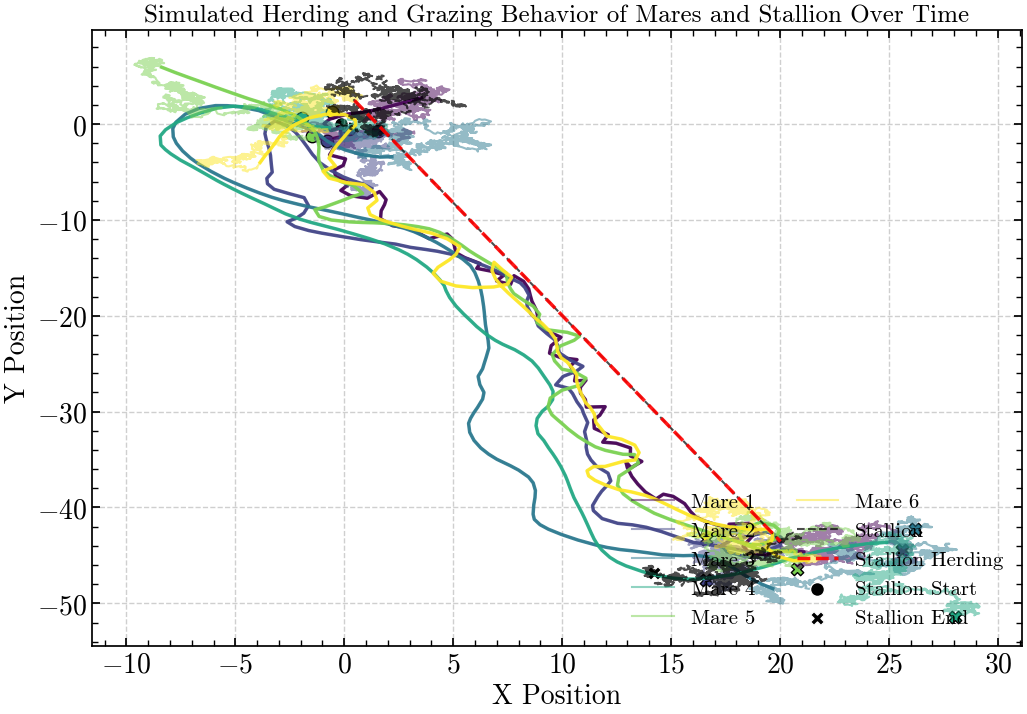

<Figure size 350x262.5 with 0 Axes>

In [ ]:
def simulate_herding_data(
    time_steps=30,
    num_mares=6,
    herding_start=11,
    herding_end=20,
    coefficients=None,
    grazing_std_dev=0.5,
    stallion_movement_distance=20,
    repulsion_stallion_distance=2,
    short_repulsion_distance=4,
    medium_attraction_distance=8,
    synchronization_distance=12,
    stallion_speed=2,
):
    # Set default coefficients if none are provided
    if coefficients is None:
        coefficients = {}
        for i in range(1, num_mares + 1):
            coefficients[f"mare{i}"] = {
                "inertia": 0.5,
                "repulsion_stallion": 0.4,
                "short_repulsion": 0.3,
                "medium_attraction": 0.2,
                "synchronization": 0.2,
                "com_attraction": 0.5,
            }

    # Initialize stallion and mare positions and velocities
    stallion_pos = np.array([[0.0, 0.0]])
    mare_positions = {}
    mare_velocities = {}
    for i in range(1, num_mares + 1):
        # Random initial positions for mares
        mare_positions[f"mare{i}"] = [np.random.uniform(-2, 2, size=2)]
        # Initial velocity is zero
        mare_velocities[f"mare{i}"] = [np.array([0.0, 0.0])]

    # Initialize DataFrame for simulation data
    simulation_data = pd.DataFrame({"time": np.arange(1, time_steps + 1)})

    for t in range(1, time_steps + 1):
        # Stallion Movement
        if t < herding_start or t > herding_end:
            # Grazing: small random movement
            stallion_move = np.random.normal(0, grazing_std_dev, size=2)
        else:
            # Herding: move towards a random target
            if t == herding_start:
                target = np.random.uniform(-stallion_movement_distance, stallion_movement_distance, size=2)
                stallion_direction = target - stallion_pos[-1]
                stallion_direction /= np.linalg.norm(stallion_direction)
            stallion_move = stallion_speed * stallion_direction
        stallion_new_pos = stallion_pos[-1] + stallion_move
        stallion_pos = np.vstack([stallion_pos, stallion_new_pos])

        # Update mare positions
        if t < herding_start or t > herding_end:
            # Mares are grazing: small random movement
            for i in range(1, num_mares + 1):
                last_pos = mare_positions[f"mare{i}"][-1]
                grazing_move = np.random.normal(0, grazing_std_dev, size=2)
                new_vel = grazing_move
                new_pos = last_pos + new_vel
                mare_positions[f"mare{i}"].append(new_pos)
                mare_velocities[f"mare{i}"].append(new_vel)
        else:
            # Mares have complex behavior
            # Collect mare positions for calculations
            current_positions = []
            for i in range(1, num_mares + 1):
                current_positions.append(mare_positions[f"mare{i}"][-1])
            for i in range(1, num_mares):
                current_positions.append(stallion_pos[-1])
            current_positions = np.array(current_positions)

            # Calculate the center of mass (COM) of the mares
            com = np.mean(current_positions[:-1], axis=0)

            # Update each mare's position based on forces
            for i in range(1, num_mares + 1):
                coeffs = coefficients[f"mare{i}"]
                last_pos = mare_positions[f"mare{i}"][-1]
                last_vel = mare_velocities[f"mare{i}"][-1]

                # Inertia (normalized)
                if t == herding_start:
                    inertia_force = np.zeros(2)
                else:
                    inertia_force = last_vel
                inertia_force_norm = inertia_force / (np.linalg.norm(inertia_force) + 1e-6)

                # Repulsion from Stallion (normalized)
                vec_to_stallion = last_pos - stallion_pos[-1]
                dist_to_stallion = np.linalg.norm(vec_to_stallion)
                if dist_to_stallion < repulsion_stallion_distance:
                    repulsion_stallion_force = vec_to_stallion / (dist_to_stallion + 1e-6)
                else:
                    repulsion_stallion_force = np.zeros(2)

                # Short-Range Repulsion from other mares (normalized)
                short_repulsion_force = np.zeros(2)
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = last_pos - mare_positions[f"mare{j}"][-1]
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if dist_to_mare < short_repulsion_distance:
                            short_repulsion_force += vec_to_mare / (dist_to_mare + 1e-6)
                short_repulsion_force_norm = short_repulsion_force / (np.linalg.norm(short_repulsion_force) + 1e-6)

                # Medium-Range Attraction to other mares (normalized)
                medium_attraction_force = np.zeros(2)
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = mare_positions[f"mare{j}"][-1] - last_pos
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if short_repulsion_distance <= dist_to_mare < medium_attraction_distance:
                            medium_attraction_force += vec_to_mare / (dist_to_mare + 1e-6)
                medium_attraction_force_norm = medium_attraction_force / (np.linalg.norm(medium_attraction_force) + 1e-6)

                # Synchronization Attraction (normalized)
                synchronization_force = np.zeros(2)
                nearest_mare_vel = None
                min_dist = synchronization_distance
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = mare_positions[f"mare{j}"][-1] - last_pos
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if dist_to_mare < min_dist:
                            min_dist = dist_to_mare
                            nearest_mare_vel = mare_velocities[f"mare{j}"][-1]
                if nearest_mare_vel is not None:
                    synchronization_force = nearest_mare_vel
                    synchronization_force_norm = synchronization_force / (np.linalg.norm(synchronization_force) + 1e-6)
                else:
                    synchronization_force_norm = np.zeros(2)

                # Attraction to COM (normalized)
                vec_to_com = com - last_pos
                com_attraction_force = vec_to_com / (np.linalg.norm(vec_to_com) + 1e-6)

                # Combine forces with coefficients
                total_force = (
                    coeffs["inertia"] * inertia_force_norm
                    + coeffs["repulsion_stallion"] * repulsion_stallion_force
                    + coeffs["short_repulsion"] * short_repulsion_force_norm
                    + coeffs["medium_attraction"] * medium_attraction_force_norm
                    + coeffs["synchronization"] * synchronization_force_norm
                    + coeffs["com_attraction"] * com_attraction_force
                )
                total_force_norm = total_force / (np.linalg.norm(total_force) + 1e-6)

                # Update velocity and position
                speed = np.random.uniform(0.5, 1)  # Variable speed
                new_vel = speed * total_force_norm
                new_pos = last_pos + new_vel

                mare_positions[f"mare{i}"].append(new_pos)
                mare_velocities[f"mare{i}"].append(new_vel)

    # Collect simulation data
    for i in range(1, num_mares + 1):
        positions = np.array(mare_positions[f"mare{i}"])
        simulation_data[f"mare{i}_x"] = positions[1:, 0]
        simulation_data[f"mare{i}_y"] = positions[1:, 1]
    simulation_data["stallion_x"] = stallion_pos[1:, 0]
    simulation_data["stallion_y"] = stallion_pos[1:, 1]

    return simulation_data


def plot_herding(simulation_data, num_mares=6, herding_start=11, herding_end=20):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, num_mares))

    # Plot each mare's path with start and end markers, and highlight herding period
    for i in range(1, num_mares + 1):
        x = simulation_data[f"mare{i}_x"]
        y = simulation_data[f"mare{i}_y"]

        # Plot full path
        plt.plot(x, y, label=f"Mare {i}", color=colors[i - 1], alpha=0.5, linewidth=1.5)

        # Highlight herding period
        plt.plot(x[herding_start - 1:herding_end], y[herding_start - 1:herding_end], color=colors[i - 1], linewidth=2.5, alpha=0.9)

        # Mark start and end points
        plt.scatter(x.iloc[0], y.iloc[0], color=colors[i - 1], edgecolor="black", s=80, marker="o")
        plt.scatter(x.iloc[-1], y.iloc[-1], color=colors[i - 1], edgecolor="black", s=80, marker="X")

    # Plot stallion's path with markers for the herding period
    plt.plot(
        simulation_data["stallion_x"],
        simulation_data["stallion_y"],
        color="black",
        label="Stallion",
        linewidth=1.5,
        linestyle="--",
        alpha=0.7
    )

    # Mark herding period for stallion
    plt.plot(
        simulation_data["stallion_x"].iloc[herding_start - 1:herding_end],
        simulation_data["stallion_y"].iloc[herding_start - 1:herding_end],
        color="red",
        linewidth=2.5,
        linestyle="--",
        alpha=0.9,
        label="Stallion Herding"
    )

    # Add markers and labels for the stallion's start and end points
    plt.scatter(simulation_data["stallion_x"].iloc[0], simulation_data["stallion_y"].iloc[0], color="black", edgecolor="white", s=100, marker="o", label="Stallion Start")
    plt.scatter(simulation_data["stallion_x"].iloc[-1], simulation_data["stallion_y"].iloc[-1], color="black", edgecolor="white", s=100, marker="X", label="Stallion End")

    # Labels and grid
    plt.title("Simulated Herding and Grazing Behavior of Mares and Stallion Over Time")
    plt.rc('figure', titlesize=40)
    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend(loc="lower right", fontsize="small", ncol=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# Example usage with adjustable parameters and individual mare coefficients
num_mares = 6
coefficients = {}
for i in range(1, num_mares + 1):
    coefficients[f"mare{i}"] = {
        "inertia": np.random.uniform(0.4, 1),
        "repulsion_stallion": np.random.uniform(0.2, 0.4),
        "short_repulsion": np.random.uniform(0., 0.4),
        "medium_attraction": np.random.uniform(0., 0.5),
        "synchronization": np.random.uniform(0., 0.4),
        "com_attraction": np.random.uniform(0, 1),
    }

simulation_data = simulate_herding_data(
    time_steps=4000,
    num_mares=num_mares,
    herding_start= 1900,
    herding_end=2000,
    coefficients=coefficients,
    grazing_std_dev=0.1,
    stallion_movement_distance=10,
    stallion_speed=0.5,
)

plot_herding(simulation_data, num_mares=num_mares,herding_start=1900,
    herding_end=2000)
plt.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")

Isolation Forest Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3899
           1       0.07      0.28      0.11       101

    accuracy                           0.89      4000
   macro avg       0.52      0.59      0.53      4000
weighted avg       0.96      0.89      0.92      4000

Local Outlier Factor Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3899
           1       0.12      0.48      0.19       101

    accuracy                           0.90      4000
   macro avg       0.55      0.69      0.57      4000
weighted avg       0.96      0.90      0.93      4000

DBSCAN Evaluation:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3899
           1       0.00      0.00      0.00       101

    accuracy                           0.97      4000
   macro avg       0.49      0.50      0.49    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

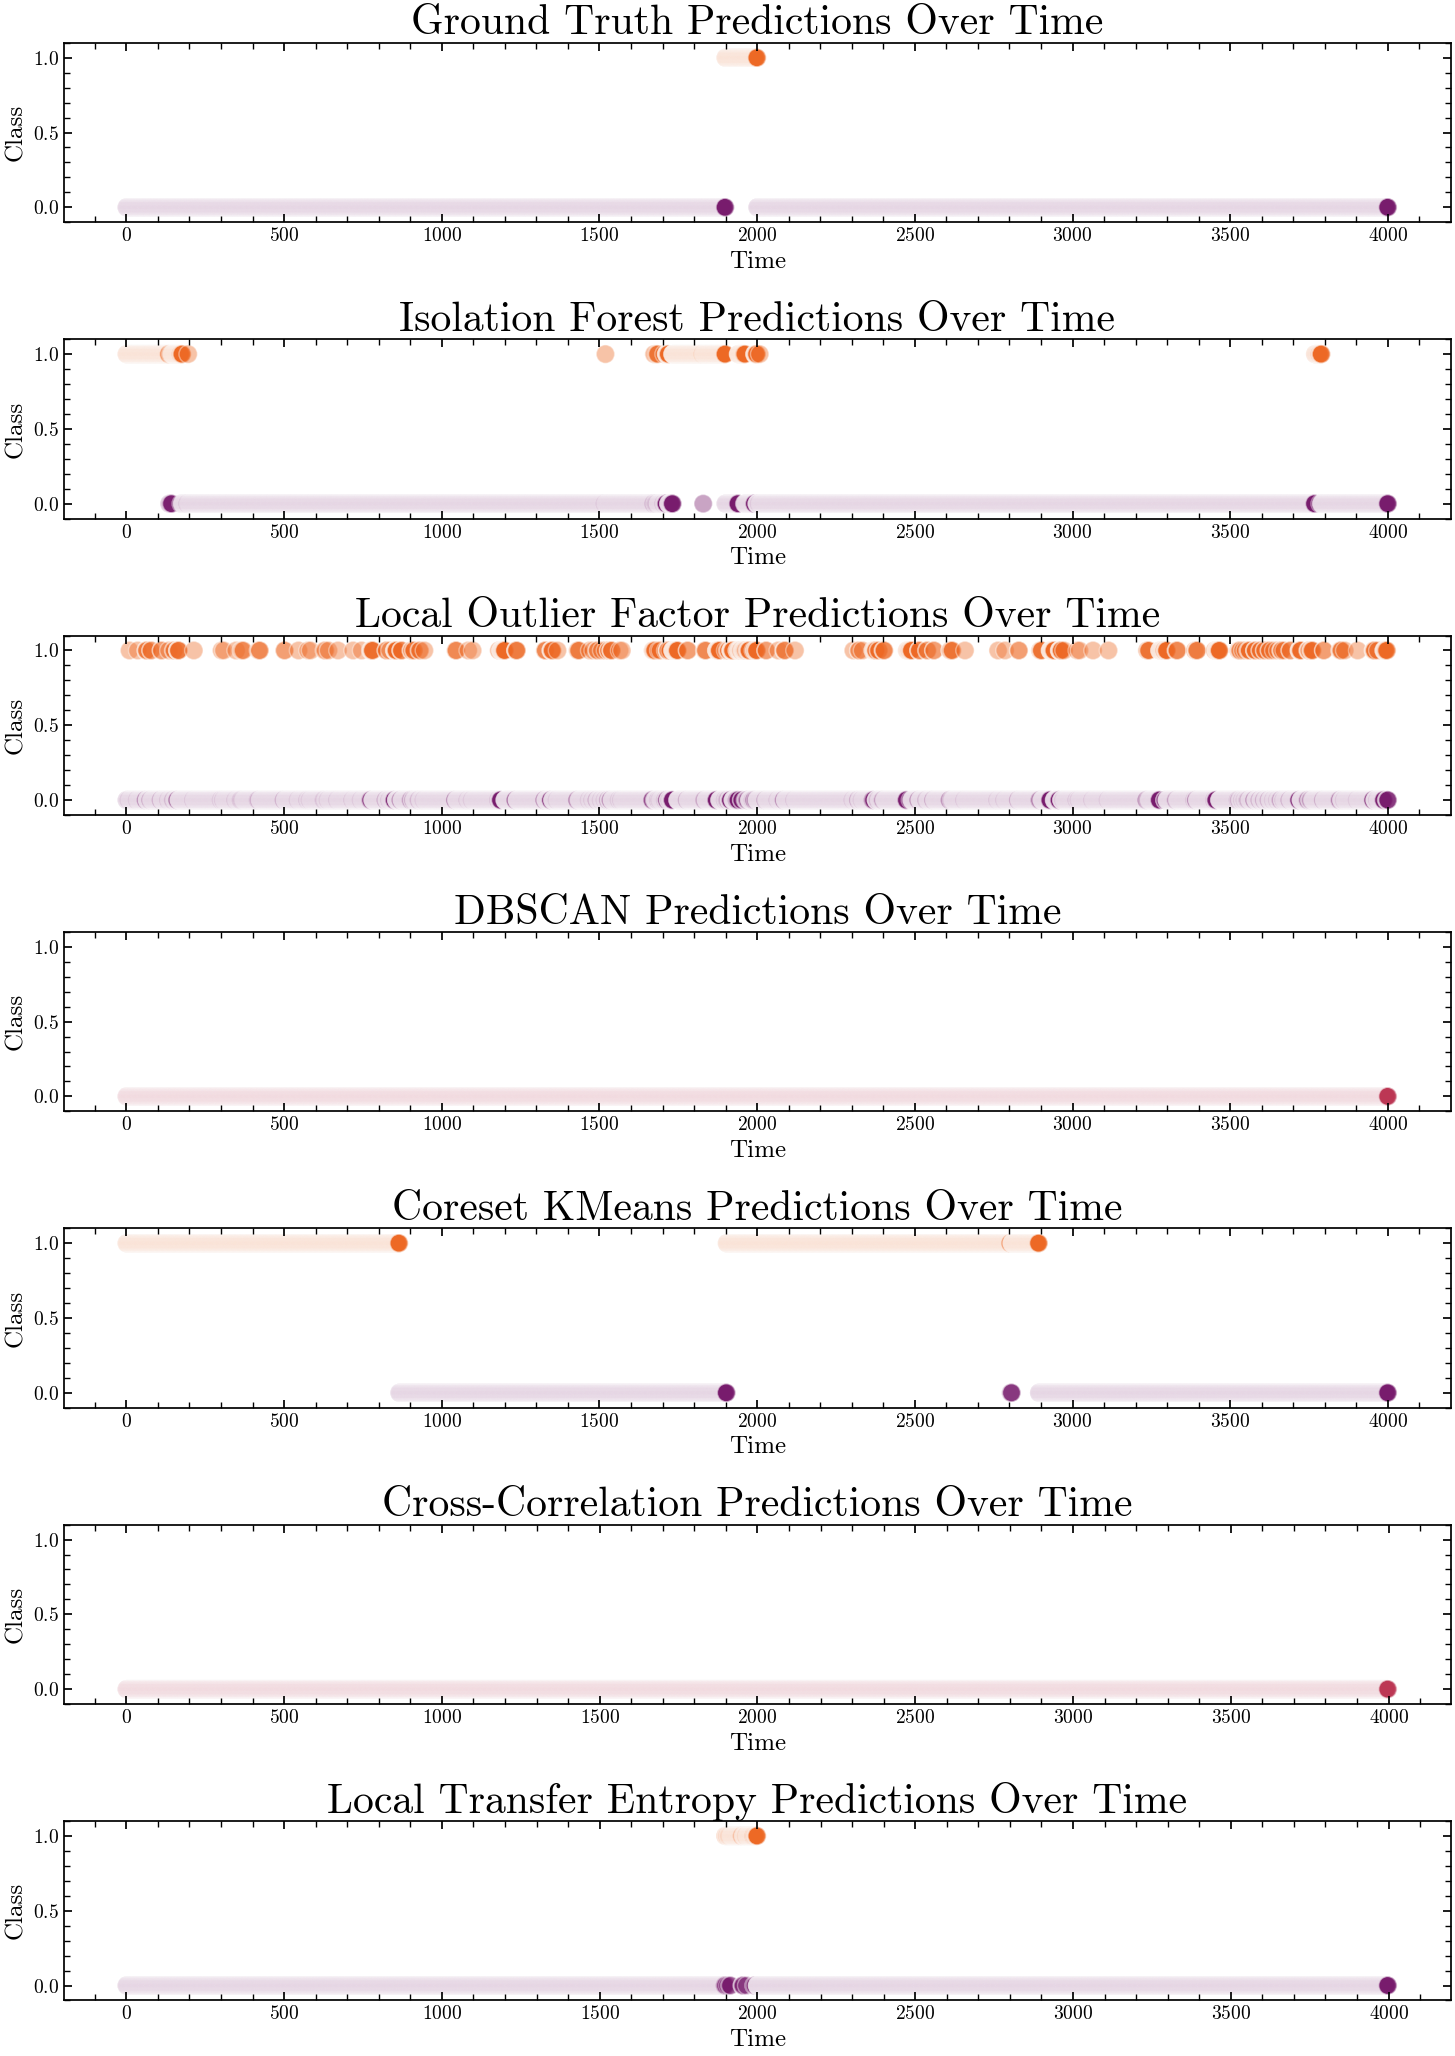

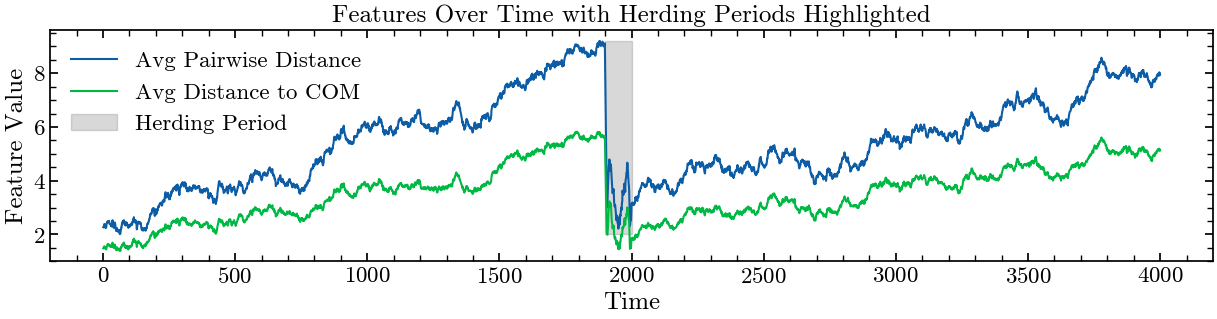

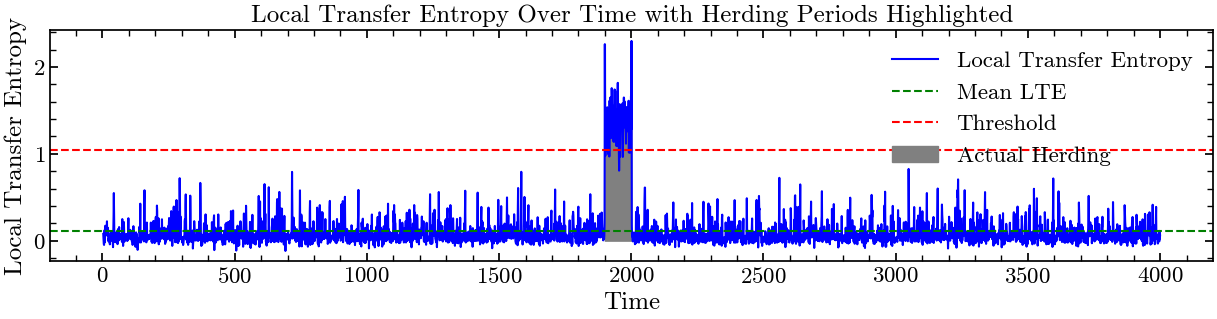

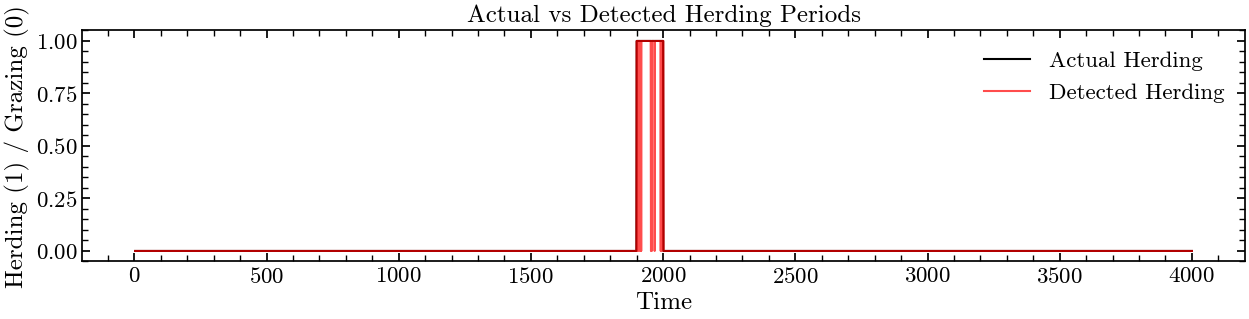

In [ ]:
plt.rcParams.update({'font.size': 20})
sns.set_context("notebook", font_scale=1.5, rc={"scatter.marker": "o", "scatter.s": 100})

def extract_features(simulation_data, num_mares=6):
    features = pd.DataFrame()
    features['time'] = simulation_data['time']
    avg_pairwise_dist = []
    std_pairwise_dist = []
    avg_distance_to_com = []

    for index, row in simulation_data.iterrows():
        # Extract positions of mares
        positions = []
        for i in range(1, num_mares + 1):
            x = row[f'mare{i}_x']
            y = row[f'mare{i}_y']
            positions.append([x, y])
        positions = np.array(positions)

        # Compute pairwise distances
        pairwise_dists = pdist(positions)
        avg_pairwise_dist.append(np.mean(pairwise_dists))
        std_pairwise_dist.append(np.std(pairwise_dists))

        # Center of mass
        com = np.mean(positions, axis=0)
        # Distance of each mare to COM
        distances_to_com = np.linalg.norm(positions - com, axis=1)
        avg_distance_to_com.append(np.mean(distances_to_com))

    features['avg_pairwise_dist'] = avg_pairwise_dist
    features['std_pairwise_dist'] = std_pairwise_dist
    features['avg_distance_to_com'] = avg_distance_to_com
    return features

def compute_movement_series(simulation_data, num_mares=6):
    # Compute movement (delta x, delta y) for stallion and mares
    movement_data = pd.DataFrame()
    movement_data['time'] = simulation_data['time'][1:].reset_index(drop=True)

    # Stallion movement
    stallion_x = simulation_data['stallion_x']
    stallion_y = simulation_data['stallion_y']
    stallion_dx = stallion_x.diff().dropna().reset_index(drop=True)
    stallion_dy = stallion_y.diff().dropna().reset_index(drop=True)
    stallion_movement = np.sqrt(stallion_dx ** 2 + stallion_dy ** 2)
    movement_data['stallion_movement'] = stallion_movement

    # Mares movement
    for i in range(1, num_mares + 1):
        mare_x = simulation_data[f'mare{i}_x']
        mare_y = simulation_data[f'mare{i}_y']
        mare_dx = mare_x.diff().dropna().reset_index(drop=True)
        mare_dy = mare_y.diff().dropna().reset_index(drop=True)
        mare_movement = np.sqrt(mare_dx ** 2 + mare_dy ** 2)
        movement_data[f'mare{i}_movement'] = mare_movement

    return movement_data

def discretize_series(series, bins=20):
    # Discretize a continuous series into specified number of bins
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    series = series.values.reshape(-1, 1)
    discretized_series = est.fit_transform(series).astype(int).flatten()
    return discretized_series

def compute_local_transfer_entropy(movement_data, k=1):
    # Get the list of horse names based on the movement columns
    horse_names = [col.replace('_movement', '') for col in movement_data.columns if col.endswith('_movement')]

    # Discretize the movement series for all horses
    horse_series = {horse: discretize_series(movement_data[f'{horse}_movement']) for horse in horse_names}

    # Find the minimum series length to ensure equal length after k-shift
    series_length = min(len(series) for series in horse_series.values())
    adjusted_length = series_length - k

    # Initialize an array to store aggregated LTE values
    total_lte = np.zeros(adjusted_length)
    num_pairs = 0

    # Compute LTE between all pairs of horses (excluding self-pairs)
    for source_horse in horse_names:
        for target_horse in horse_names:
            if source_horse != target_horse:
                source_series = horse_series[source_horse][:series_length]
                target_series = horse_series[target_horse][:series_length]
                # Compute LTE from source_horse to target_horse
                lte = transfer_entropy(source_series, target_series, k=k, local=True)
                # Aggregate LTE values
                total_lte += lte.reshape(-1)
                num_pairs += 1

    # Average LTE across all pairs
    avg_lte = total_lte / num_pairs
    # Adjust the movement data to align with the LTE values
    movement_data = movement_data.iloc[k:series_length].reset_index(drop=True)
    movement_data['local_transfer_entropy'] = avg_lte
    return movement_data

def identify_herding_periods(movement_data, threshold=None):
    # Identify periods of high local transfer entropy
    if threshold is None:
        # Set threshold as mean plus one standard deviation
        threshold = movement_data['local_transfer_entropy'].mean() + 4*movement_data['local_transfer_entropy'].std()

    movement_data['herding_detected'] = movement_data['local_transfer_entropy'].apply(lambda x: 1 if x >= threshold else 0)
    return movement_data, threshold

def construct_coreset(features, coreset_size):
    # Implementing a simple coreset using k-means++ initialization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])
    # Initialize centers
    initial_center = X_scaled[np.random.choice(X_scaled.shape[0], 1)]
    centers = [initial_center[0]]
    for _ in range(1, coreset_size):
        dist_sq = np.min([np.sum((X_scaled - center) ** 2, axis=1) for center in centers], axis=0)
        probabilities = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probabilities)
        r = np.random.rand()
        index = np.searchsorted(cumulative_probs, r)
        centers.append(X_scaled[index])
    coreset = np.array(centers)
    return coreset

def apply_anomaly_detection(features):
    # Apply anomaly detection methods to features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])

    # Isolation Forest
    iso_clf = IsolationForest(contamination=0.1, random_state=42)
    iso_clf.fit(X_scaled)
    iso_scores = iso_clf.decision_function(X_scaled)
    iso_outliers = iso_clf.predict(X_scaled)
    features['isolation_forest_score'] = iso_scores
    features['isolation_forest_outlier'] = iso_outliers

    # Local Outlier Factor
    lof_clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    lof_outliers = lof_clf.fit_predict(X_scaled)
    lof_scores = lof_clf.negative_outlier_factor_
    features['lof_score'] = lof_scores
    features['lof_outlier'] = lof_outliers

    # DBSCAN
    dbscan_clustering = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
    features['dbscan_labels'] = dbscan_clustering.labels_

    # Coreset KMeans
    coreset_size = 100  # Adjust the coreset size as needed
    coreset = construct_coreset(features, coreset_size)
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(coreset)
    full_predictions = kmeans.predict(X_scaled)
    features['coreset_kmeans_labels'] = full_predictions

    return features

from statsmodels.tsa.stattools import ccf

# --- CCF-based detector ---
def compute_crosscorr_detector(movement_data, threshold_multiplier=1.0):
    horse_cols = [col for col in movement_data if col.endswith('_movement')]
    series = {h: movement_data[h].values for h in horse_cols}
    T = len(next(iter(series.values())))
    sum_corr = np.zeros(T)
    count = 0

    for src in horse_cols:
        for tgt in horse_cols:
            if src == tgt:
                continue
            rho = np.corrcoef(series[src], series[tgt])[0,1]
            sum_corr += rho
            count += 1

    avg_ccf = sum_corr / count
    df = movement_data.copy().reset_index(drop=True)
    df['avg_ccf'] = avg_ccf
    thr = df['avg_ccf'].mean() + threshold_multiplier * df['avg_ccf'].std()
    df['herd_ccf'] = (df['avg_ccf'] >= thr).astype(int)
    return df, thr

def evaluate_methods(features, movement_data, herding_start, herding_end):
    # Create ground truth labels: 1 for herding period, 0 for grazing
    ground_truth = features['time'].apply(lambda x: 1 if herding_start <= x <= herding_end else 0)
    features['herding'] = ground_truth

    # Adjust ground truth for movement data
    adjusted_ground_truth = ground_truth.iloc[2:].reset_index(drop=True)
    movement_data['herding_ground_truth'] = adjusted_ground_truth

    # Isolation Forest
    isof_outliers = features['isolation_forest_outlier'].replace({1: 0, -1: 1})
    print("Isolation Forest Evaluation:")
    print(classification_report(ground_truth, isof_outliers))

    # Local Outlier Factor
    lof_outliers = features['lof_outlier'].replace({1: 0, -1: 1})
    print("Local Outlier Factor Evaluation:")
    print(classification_report(ground_truth, lof_outliers))

    # DBSCAN Evaluation
    dbscan_labels = features['dbscan_labels']
    # Map DBSCAN labels to ground truth labels
    grazing_label = dbscan_labels[ground_truth == 0].mode().iloc[0]
    dbscan_predictions = dbscan_labels.apply(lambda x: 0 if x == grazing_label else 1)
    print("DBSCAN Evaluation:")
    print(classification_report(ground_truth, dbscan_predictions))

    # Coreset KMeans Evaluation
    coreset_labels = features['coreset_kmeans_labels']
    grazing_label = coreset_labels[ground_truth == 0].mode().iloc[0]
    coreset_predictions = coreset_labels.apply(lambda x: 0 if x == grazing_label else 1)
    print("Coreset KMeans Evaluation:")
    print(classification_report(ground_truth, coreset_predictions))

    # CCF eval
    df_ccf, thr_ccf = compute_crosscorr_detector(movement_data, threshold_multiplier=4)
    ccf_pred = df_ccf['herd_ccf']
    print("Cross-Correlation (threshold m={}):\n".format(0.5),
          classification_report(adjusted_ground_truth, ccf_pred))

    # Local Transfer Entropy Evaluation
    lte_predictions = movement_data['herding_detected']
    print("Local Transfer Entropy Evaluation:")
    print(classification_report(adjusted_ground_truth, lte_predictions))

    # Visualizations
    visualize_results(
        features,
        movement_data,
        ground_truth,
        isof_outliers,
        lof_outliers,
        dbscan_predictions,
        coreset_predictions,
        ccf_pred,
        lte_predictions,
        adjusted_ground_truth
    )

def visualize_results(
    features,
    movement_data,
    ground_truth,
    isof_outliers,
    lof_outliers,
    dbscan_predictions,
    coreset_predictions,
    ccf_pred,
    lte_predictions,
    adjusted_ground_truth
):
    # Plotting function to visualize the results
    methods = {
        'Ground Truth': ground_truth,
        'Isolation Forest': isof_outliers,
        'Local Outlier Factor': lof_outliers,
        'DBSCAN': dbscan_predictions,
        'Coreset KMeans': coreset_predictions,
        'Cross-Correlation': ccf_pred,
        'Local Transfer Entropy': lte_predictions
    }

    time = features['time']
    plt.figure(figsize=(15, 21))
    for idx, (method_name, predictions) in enumerate(methods.items(), 1):
        plt.subplot(len(methods), 1, idx)
        sns.scatterplot(
            x=time,
            y=predictions,
            hue=predictions,
            palette='inferno',
            s=175,  # Increased size for better visibility
            legend=False,
            alpha=0.4  # Improved transparency for clarity
        )
        plt.title(f"{method_name} Predictions Over Time", fontsize=30)  # Enlarged title font
        plt.ylabel('Class', fontsize=18)  # Enlarged y-axis label font
        plt.xlabel('Time', fontsize=18)  # Enlarged x-axis label font
        plt.ylim(-0.1, 1.1)
        plt.xticks(fontsize=14)  # Larger x-tick labels
        plt.yticks(fontsize=14)  # Larger y-tick labels
    plt.tight_layout()
    plt.savefig("myImagePDF1.pdf", format="pdf", bbox_inches="tight")
    plt.show()



    # Additional visualization: Plot the features over time with herding periods highlighted
    plt.figure(figsize=(15, 3))
    plt.plot(features['time'], features['avg_pairwise_dist'], label='Avg Pairwise Distance')
    plt.plot(features['time'], features['avg_distance_to_com'], label='Avg Distance to COM')
    plt.fill_between(
        features['time'],
        features['avg_pairwise_dist'].min(),
        features['avg_pairwise_dist'].max(),
        where=ground_truth == 1,
        color='gray',
        alpha=0.3,
        label='Herding Period'
    )
    plt.xlabel('Time')
    plt.ylabel('Feature Value')
    plt.title('Features Over Time with Herding Periods Highlighted')
    plt.legend()
    plt.savefig("myImagePDF2.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Visualize Local Transfer Entropy
    plt.figure(figsize=(15, 3))
    plt.plot(
        movement_data['time'],
        movement_data['local_transfer_entropy'],
        label='Local Transfer Entropy',
        color='blue'
    )
    plt.axhline(
        y=movement_data['local_transfer_entropy'].mean(),
        color='green',
        linestyle='--',
        label='Mean LTE'
    )
    plt.axhline(
        y=movement_data['local_transfer_entropy'].mean() + 4*movement_data['local_transfer_entropy'].std(),
        color='red',
        linestyle='--',
        label='Threshold'
    )
    plt.fill_between(
        movement_data['time'],
        movement_data['local_transfer_entropy'],
        where=(adjusted_ground_truth == 1),
        color='gray',
        alpha=1,
        label='Actual Herding'
    )
    plt.xlabel('Time')
    plt.ylabel('Local Transfer Entropy')
    plt.title('Local Transfer Entropy Over Time with Herding Periods Highlighted')
    plt.legend()
    plt.savefig("myImagePDF3.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def visualize_herding_detection(movement_data):
    # Visualize the detected herding periods against the ground truth
    plt.figure(figsize=(15, 3))
    plt.plot(movement_data['time'], movement_data['herding_ground_truth'], label='Actual Herding', color='black')
    plt.plot(movement_data['time'], movement_data['herding_detected'], label='Detected Herding', color='red', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Herding (1) / Grazing (0)')
    plt.title('Actual vs Detected Herding Periods')
    plt.legend()
    plt.show()

# Parameters
num_mares = 6  # Adjust as per your data
herding_start = 1900
herding_end = 2000

# Use the functions with simulation data
features = extract_features(simulation_data, num_mares=num_mares)
movement_data = compute_movement_series(simulation_data, num_mares=num_mares)

# Compute local transfer entropy
movement_data = compute_local_transfer_entropy(movement_data, k=1)

# Identify herding periods based on local transfer entropy
movement_data, threshold = identify_herding_periods(movement_data)

# Apply anomaly detection methods
features = apply_anomaly_detection(features)

# Evaluate the methods
evaluate_methods(features, movement_data, herding_start, herding_end)

# Visualize herding detection
visualize_herding_detection(movement_data)

### Clustering Method Assessment

In [ ]:
# Define parameter grid
param_grid = {
    'distance': [0.5, 1.0, 1.5],  # Example distances in arbitrary units
    'herding_time': [100, 200, 300],  # Example times
    'coefficients_of_horses': [0.1, 0.5, 1.0],  # Example coefficients
    'grazing_time': [50, 150, 250],  # Example grazing times
    'num_mares': [4, 6, 8],  # Different numbers of mares
    'stallion_speed': [0.2, 0.5, 1.0]  # Example speeds
}

# Function to run experiment
def run_experiment(params, simulation_data):
    num_mares = params['num_mares']

    # Generate features based on the parameters and extracted simulation data
    features = extract_features(simulation_data, num_mares=num_mares)
    movement_data = compute_movement_series(simulation_data, num_mares=num_mares)
    movement_data = compute_local_transfer_entropy(movement_data, k=1)
    movement_data, threshold = identify_herding_periods(movement_data)

    # Apply clustering and anomaly detection methods
    features = apply_anomaly_detection(features)

    # Define herding period based on params
    herding_start = params['herding_time'] // 2
    herding_end = params['herding_time']

    # Adjust ground truth labels for evaluation
    ground_truth = features['time'].apply(lambda x: 1 if herding_start <= x <= herding_end else 0)
    features['herding'] = ground_truth
    adjusted_ground_truth = ground_truth.iloc[2:].reset_index(drop=True)  # Aligning to movement data

    # Truncate ground truth to match predictions in length
    results = {}
    for method in ['isolation_forest_outlier', 'lof_outlier', 'dbscan_labels', 'coreset_kmeans_labels', 'herding_detected']:
        if method in features:
            predictions = features[method]
        else:
            predictions = movement_data[method]

        # Truncate predictions if needed to ensure consistent length with adjusted ground truth
        min_length = min(len(adjusted_ground_truth), len(predictions))
        truncated_ground_truth = adjusted_ground_truth[:min_length]
        truncated_predictions = predictions[:min_length]

        if method == 'dbscan_labels':
            # Map DBSCAN labels to binary classification
            grazing_label = truncated_predictions[truncated_ground_truth == 0].mode().iloc[0]
            truncated_predictions = truncated_predictions.apply(lambda x: 0 if x == grazing_label else 1)

        # Calculate metrics
        accuracy = accuracy_score(truncated_ground_truth, truncated_predictions)
        f1 = f1_score(truncated_ground_truth, truncated_predictions, average=None)

        results[method] = {
            'accuracy': accuracy,
            'f1_score': f1
        }

    return results

# Loop over all parameter combinations and collect results
from itertools import product

# Store results across parameter sets
all_results = []

for values in product(*param_grid.values()):
    param_set = dict(zip(param_grid.keys(), values))
    result = run_experiment(param_set, simulation_data)
    all_results.append({**param_set, **result})

# Convert to DataFrame for visualization
results_df = pd.DataFrame(all_results)

KeyError: 'mare5_x'

In [ ]:
methods = ['isolation_forest_outlier', 'lof_outlier', 'dbscan_labels', 'coreset_kmeans_labels', 'herding_detected']

# Transform results_df into a long format
rows = []

for idx, row in results_df.iterrows():
    # Extract parameters
    params = row[['distance', 'herding_time', 'coefficients_of_horses', 'grazing_time', 'num_mares', 'stallion_speed']]
    params_dict = params.to_dict()

    # Iterate over each method to extract metrics
    for method in methods:
        if method in row:
            metrics = row[method]
            if metrics is not None:
                accuracy = metrics.get('accuracy', None)
                f1_score = metrics.get('f1_score', None)
                # Compute average F1 score if it's a list
                if isinstance(f1_score, (list, np.ndarray)):
                    f1_score = np.mean(f1_score)
                # Append the data to rows
                row_dict = {**params_dict, 'method': method, 'accuracy': accuracy, 'f1_score': f1_score}
                rows.append(row_dict)

# Create a long-format DataFrame
results_long_df = pd.DataFrame(rows)

# Display the first few rows
print(results_long_df.head())

### Visualization

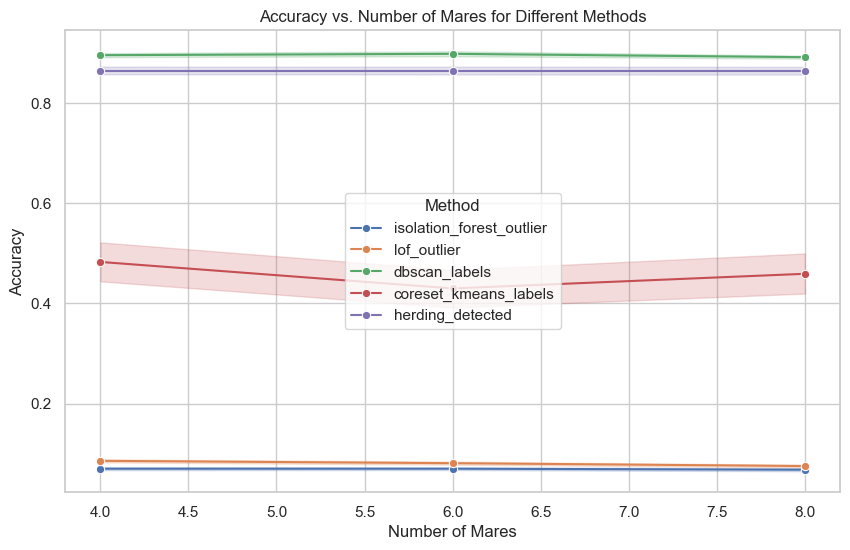

In [ ]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_long_df, x='num_mares', y='accuracy', hue='method', marker='o')
plt.title('Accuracy vs. Number of Mares for Different Methods')
plt.xlabel('Number of Mares')
plt.ylabel('Accuracy')
plt.legend(title='Method')
plt.show()

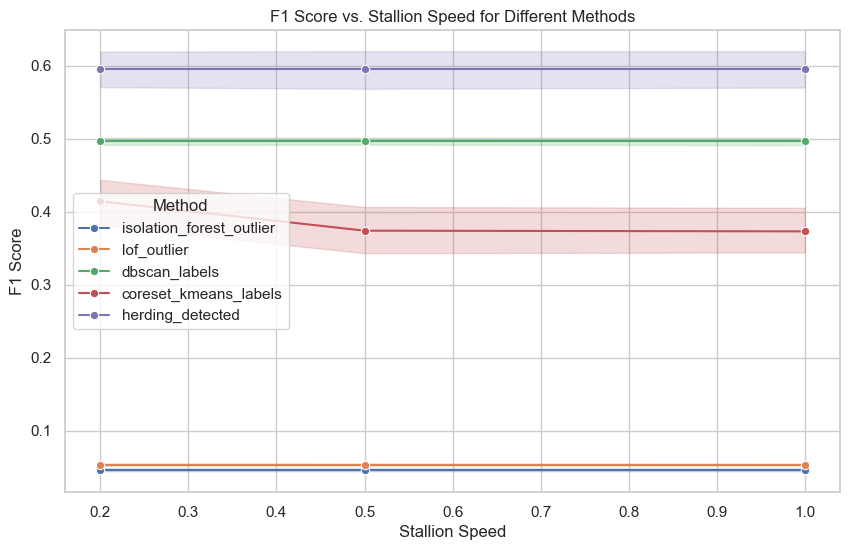

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_long_df, x='stallion_speed', y='f1_score', hue='method', marker='o')
plt.title('F1 Score vs. Stallion Speed for Different Methods')
plt.xlabel('Stallion Speed')
plt.ylabel('F1 Score')
plt.legend(title='Method')
plt.show()


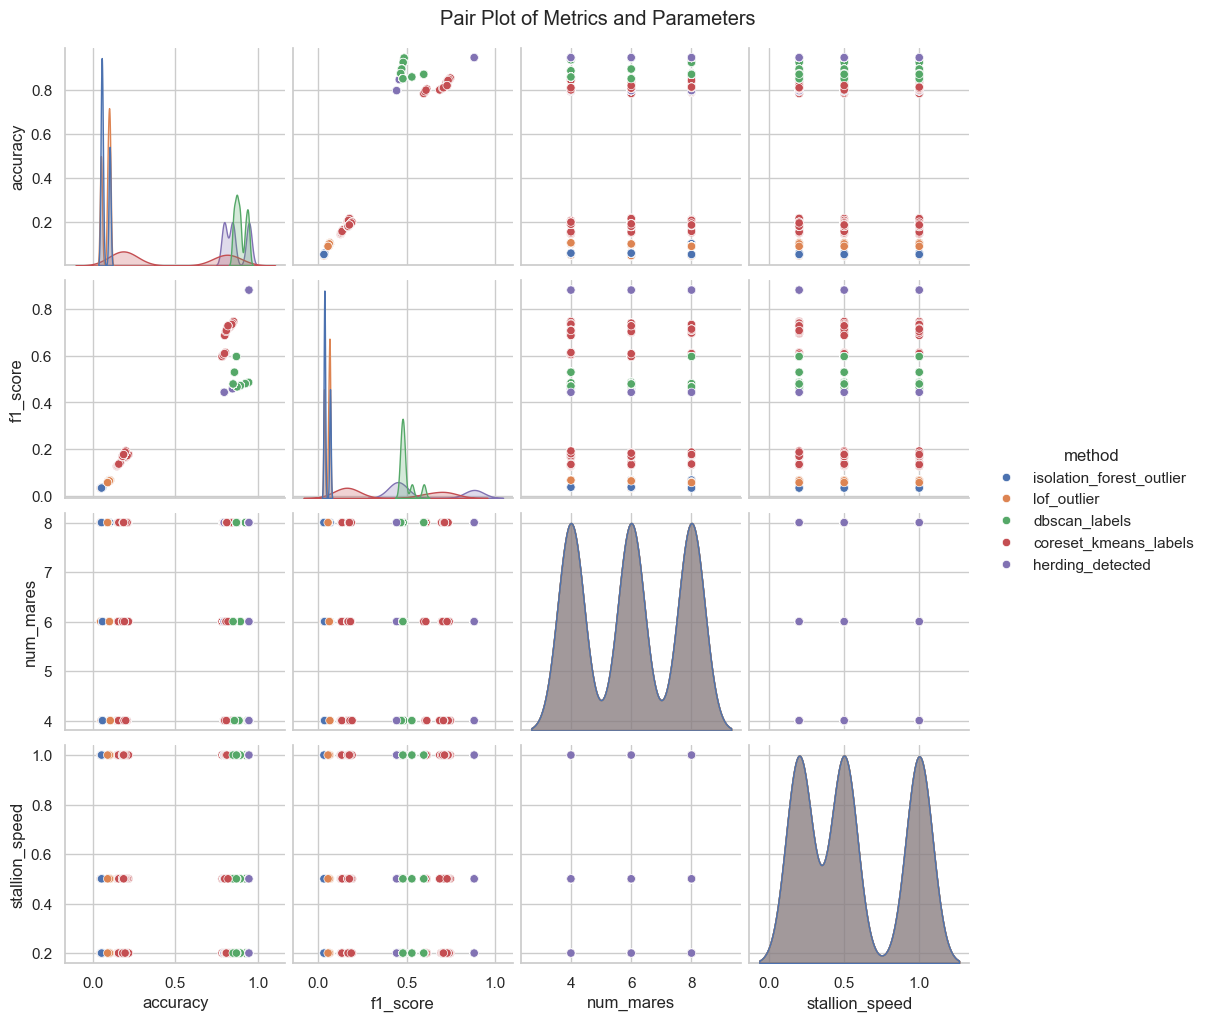

In [ ]:
# Select relevant columns for the pair plot
pairplot_df = results_long_df[['accuracy', 'f1_score', 'num_mares', 'stallion_speed', 'method']]

# Create a pair plot
sns.pairplot(pairplot_df, hue='method', vars=['accuracy', 'f1_score', 'num_mares', 'stallion_speed'])
plt.suptitle('Pair Plot of Metrics and Parameters', y=1.02)
plt.show()


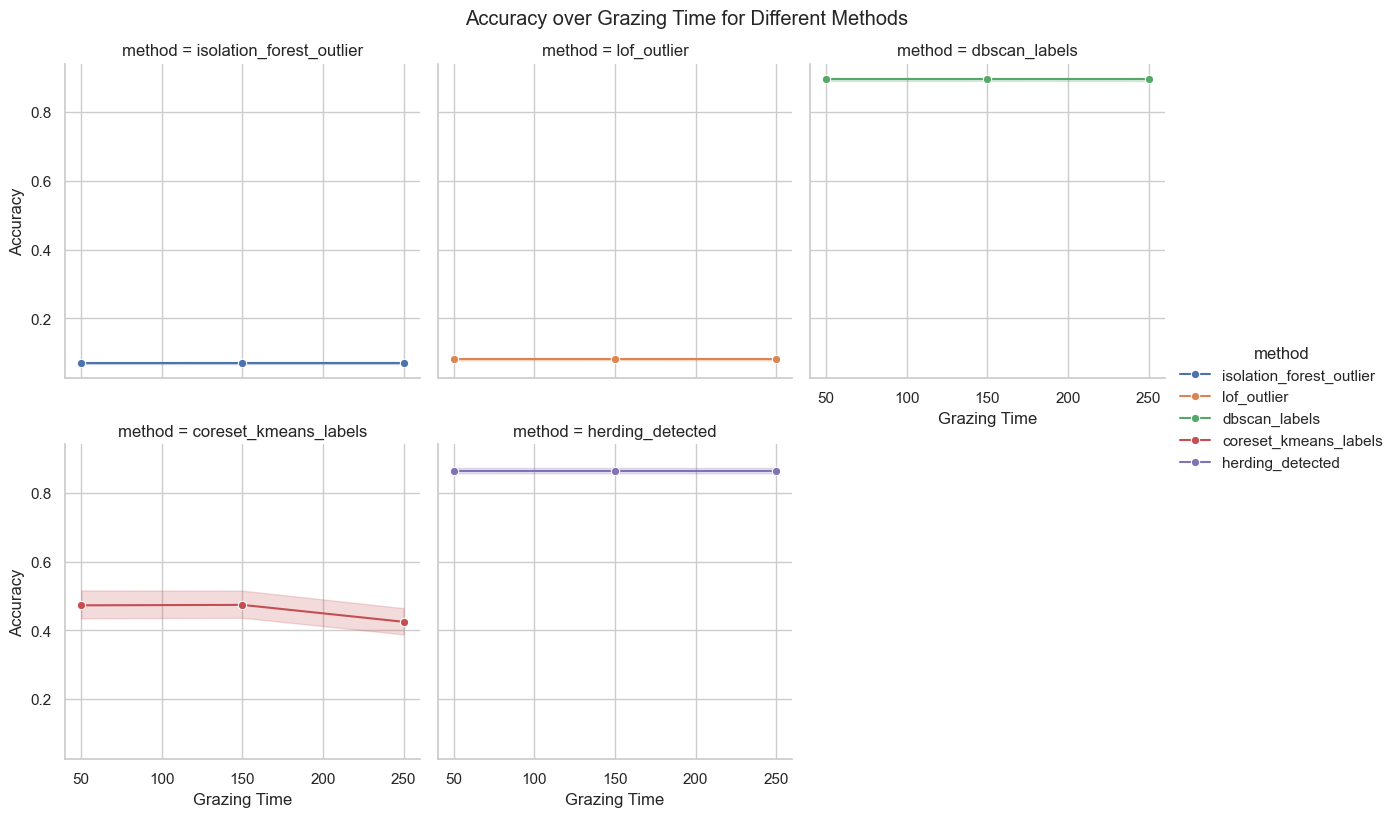

In [ ]:
g = sns.FacetGrid(results_long_df, col='method', hue='method', col_wrap=3, height=4)
g.map(sns.lineplot, 'grazing_time', 'accuracy', marker='o')
g.add_legend()
g.set_axis_labels('Grazing Time', 'Accuracy')
g.fig.suptitle('Accuracy over Grazing Time for Different Methods', y=1.02)
plt.show()

### Training

#### Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist
from openpyxl import load_workbook
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

#### Data Loading

In [ ]:
def read_excel_data_with_colors(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                 if f.endswith('.xlsx') or f.endswith('.xls')]
    data_frames = {}
    for file in all_files:
        # Read data with pandas
        df = pd.read_excel(file)
        # Read colors using openpyxl
        wb = load_workbook(file, data_only=True)
        ws = wb.active  # Or specify the sheet if needed

        colors = []
        for row in ws.iter_rows(min_row=2, min_col=1, max_col=1):  # Assuming headers in the first row
            cell = row[0]
            fill = cell.fill
            fgColor = fill.fgColor
            if fgColor.type == 'rgb':
                color_code = fgColor.rgb
            elif fgColor.type == 'indexed':
                # Map indexed colors to RGB if possible
                if fgColor.indexed == 64:
                    color_code = 'FFFFFF'  # Default background color (white)
                else:
                    color_code = str(fgColor.indexed)
            else:
                color_code = None
            colors.append(color_code)

        # Map colors to herding labels
        herding_labels = []
        for color in colors:
            if color is None or color.upper() in ['FFFFFF', 'FFFFFFFF']:
                herding_labels.append(0)  # White color indicates non-herding
            else:
                herding_labels.append(1)  # Non-white color indicates herding

        # Align data and labels
        df = df.reset_index(drop=True)
        df['herding'] = herding_labels
        # Store each DataFrame with its filename as the key
        data_frames[os.path.basename(file)] = df
    return data_frames


In [ ]:
def extract_features_from_data(data):
    # Identify mare columns dynamically
    mare_x_columns = [col for col in data.columns if col.endswith('_x') and col != 'kobe_x']
    mare_names = [col[:-2] for col in mare_x_columns]  # Remove '_x' to get mare names

    features = pd.DataFrame()
    if 'time' in data.columns:
        features['time'] = data['time']

    avg_pairwise_dist = []
    std_pairwise_dist = []
    avg_distance_to_com = []

    for index, row in data.iterrows():
        # Extract positions of mares
        positions = []
        for mare_name in mare_names:
            x = row.get(f'{mare_name}_x', np.nan)
            y = row.get(f'{mare_name}_y', np.nan)
            if pd.notna(x) and pd.notna(y):
                positions.append([x, y])
        positions = np.array(positions)

        # Compute pairwise distances
        if len(positions) > 1:
            pairwise_dists = pdist(positions)
            avg_pairwise_dist.append(np.mean(pairwise_dists))
            std_pairwise_dist.append(np.std(pairwise_dists))
        else:
            avg_pairwise_dist.append(0)
            std_pairwise_dist.append(0)

        # Center of mass
        if len(positions) > 0:
            com = np.mean(positions, axis=0)
            distances_to_com = np.linalg.norm(positions - com, axis=1)
            avg_distance_to_com.append(np.mean(distances_to_com))
        else:
            avg_distance_to_com.append(0)

    features['avg_pairwise_dist'] = avg_pairwise_dist
    features['std_pairwise_dist'] = std_pairwise_dist
    features['avg_distance_to_com'] = avg_distance_to_com
    return features


In [ ]:
def compute_movement_series_from_data(data):
    mare_x_columns = [col for col in data.columns if col.endswith('_x') and col != 'kobe_x']
    mare_names = [col[:-2] for col in mare_x_columns]  # Remove '_x' to get mare names

    movement_data = pd.DataFrame()
    if 'time' in data.columns:
        movement_data['time'] = data['time'][1:].reset_index(drop=True)
    else:
        movement_data['time'] = data.index[1:].reset_index(drop=True)

    # Stallion movement (kobe)
    if 'kobe_x' in data.columns and 'kobe_y' in data.columns:
        kobe_x = data['kobe_x']
        kobe_y = data['kobe_y']
        kobe_dx = kobe_x.diff().dropna().reset_index(drop=True)
        kobe_dy = kobe_y.diff().dropna().reset_index(drop=True)
        kobe_movement = np.sqrt(kobe_dx ** 2 + kobe_dy ** 2)
        movement_data['kobe_movement'] = kobe_movement

    # Mares movement
    for mare_name in mare_names:
        mare_x = data[f'{mare_name}_x']
        mare_y = data[f'{mare_name}_y']
        mare_dx = mare_x.diff().dropna().reset_index(drop=True)
        mare_dy = mare_y.diff().dropna().reset_index(drop=True)
        mare_movement = np.sqrt(mare_dx ** 2 + mare_dy ** 2)
        movement_data[f'{mare_name}_movement'] = mare_movement

    return movement_data


#### Hyperparameter Grids

In [ ]:

# Your parameter grids
lof_param_grid = {
    'n_neighbors': [5, 10, 20, 35, 50],
    'algorithm': ['auto', 'kd_tree'],
    'leaf_size': [30, 40, 50],
    'metric': ['euclidean', 'manhattan'],
    'contamination': [0.05, 0.1, 0.15],
    'n_jobs': [-1]
}

dbscan_param_grid = {
    'eps': [0.1, 0.3, 0.5, 0.7, 1.0],
    'min_samples': [5, 10, 15],
    'metric': ['euclidean', 'manhattan']
}

kmeans_param_grid = {
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300, 500, 700],
    'random_state': [42],
    'algorithm': ['lloyd', 'elkan']
}

te_param_grid = {
    'k': [1, 2, 3, 4, 5],
    'threshold_multiplier': [0.5, 1.0, 1.5, 2.0]
}

iso_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 0.5, 0.75],
    'contamination': [0.05, 0.1, 0.15],
    'max_features': [1.0, 0.5, 0.75],
    'bootstrap': [False],
    'n_jobs': [-1],
    'random_state': [42]
}

coreset_param_grid = {
    'coreset_size': [50, 100, 150],
    'n_clusters': [2],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500],
    'algorithm': ['lloyd', 'elkan'],
    'random_state': [42]
}

#### Helper Functions

In [ ]:
def read_excel_data_with_colors(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                 if f.endswith('.xlsx') or f.endswith('.xls')]
    data_frames = {}
    for file in all_files:
        # Read data with pandas
        df = pd.read_excel(file)
        # Read colors using openpyxl
        wb = load_workbook(file, data_only=True)
        ws = wb.active  # Or specify the sheet if needed

        colors = []
        for row in ws.iter_rows(min_row=2, min_col=1, max_col=1):  # Assuming headers in the first row
            cell = row[0]
            fill = cell.fill
            fgColor = fill.fgColor
            if fgColor.type == 'rgb':
                color_code = fgColor.rgb
            elif fgColor.type == 'indexed':
                # Map indexed colors to RGB if possible
                if fgColor.indexed == 64:
                    color_code = 'FFFFFF'  # Default background color (white)
                else:
                    color_code = str(fgColor.indexed)
            else:
                color_code = None
            colors.append(color_code)

        # Map colors to herding labels
        herding_labels = []
        for color in colors:
            if color is None or color.upper() in ['FFFFFF', 'FFFFFFFF']:
                herding_labels.append(0)  # White color indicates non-herding
            else:
                herding_labels.append(1)  # Non-white color indicates herding

        # Align data and labels
        df = df.reset_index(drop=True)
        df['herding'] = herding_labels
        # Store each DataFrame with its filename as the key
        data_frames[os.path.basename(file)] = df
    return data_frames

def extract_features_from_data(data):
    # Identify mare columns dynamically
    mare_x_columns = [col for col in data.columns if col.endswith('_x') and col.startswith('mare')]
    mare_names = [col[:-2] for col in mare_x_columns]  # Remove '_x' to get mare names

    features = pd.DataFrame()
    if 'time' in data.columns:
        features['time'] = data['time']

    avg_pairwise_dist = []
    std_pairwise_dist = []
    avg_distance_to_com = []

    for index, row in data.iterrows():
        # Extract positions of mares
        positions = []
        for mare_name in mare_names:
            x = row.get(f"{mare_name}_x", np.nan)
            y = row.get(f"{mare_name}_y", np.nan)
            if pd.notna(x) and pd.notna(y):
                positions.append([x, y])
        positions = np.array(positions)

        # Compute pairwise distances
        if len(positions) > 1:
            pairwise_dists = pdist(positions)
            avg_pairwise_dist.append(np.mean(pairwise_dists))
            std_pairwise_dist.append(np.std(pairwise_dists))
        else:
            avg_pairwise_dist.append(0)
            std_pairwise_dist.append(0)

        # Center of mass
        if len(positions) > 0:
            com = np.mean(positions, axis=0)
            distances_to_com = np.linalg.norm(positions - com, axis=1)
            avg_distance_to_com.append(np.mean(distances_to_com))
        else:
            avg_distance_to_com.append(0)

    features['avg_pairwise_dist'] = avg_pairwise_dist
    features['std_pairwise_dist'] = std_pairwise_dist
    features['avg_distance_to_com'] = avg_distance_to_com
    return features

def compute_movement_series(data):
    mare_x_columns = [col for col in data.columns if col.endswith('_x') and col.startswith('mare')]
    mare_names = [col[:-2] for col in mare_x_columns]  # Remove '_x' to get mare names

    movement_data = pd.DataFrame()
    if 'time' in data.columns:
        movement_data['time'] = data['time'][1:].reset_index(drop=True)
    else:
        movement_data['time'] = data.index[1:].reset_index(drop=True)

    # Stallion movement (if present)
    if 'stallion_x' in data.columns and 'stallion_y' in data.columns:
        stallion_x = data['stallion_x']
        stallion_y = data['stallion_y']
        stallion_dx = stallion_x.diff().dropna().reset_index(drop=True)
        stallion_dy = stallion_y.diff().dropna().reset_index(drop=True)
        stallion_movement = np.sqrt(stallion_dx ** 2 + stallion_dy ** 2)
        movement_data['stallion_movement'] = stallion_movement

    # Mares movement
    if mare_names:
        for mare_name in mare_names:
            mare_x = data[f"{mare_name}_x"]
            mare_y = data[f"{mare_name}_y"]
            mare_dx = mare_x.diff().dropna().reset_index(drop=True)
            mare_dy = mare_y.diff().dropna().reset_index(drop=True)
            mare_movement = np.sqrt(mare_dx ** 2 + mare_dy ** 2)
            movement_data[f"{mare_name}_movement"] = mare_movement
    else:
        raise ValueError("No mare data found in the dataset.")

    return movement_data

def discretize_series(series, bins=20):
    # Discretize a continuous series into specified number of bins
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    series = series.values.reshape(-1, 1)
    discretized_series = est.fit_transform(series).astype(int).flatten()
    return discretized_series

def compute_local_transfer_entropy(movement_data, k=1):
    # Get the list of horse names based on the movement columns
    horse_names = [col.replace('_movement', '') for col in movement_data.columns if col.endswith('_movement')]

    # Discretize the movement series for all horses
    horse_series = {horse: discretize_series(movement_data[f'{horse}_movement']) for horse in horse_names}

    # Find the minimum series length to ensure equal length after k-shift
    series_length = min(len(series) for series in horse_series.values())
    adjusted_length = series_length - k

    # Initialize an array to store aggregated LTE values
    total_lte = np.zeros(adjusted_length)
    num_pairs = 0

    # Compute LTE between all pairs of horses (excluding self-pairs)
    for source_horse in horse_names:
        for target_horse in horse_names:
            if source_horse != target_horse:
                source_series = horse_series[source_horse][:series_length]
                target_series = horse_series[target_horse][:series_length]
                # Compute LTE from source_horse to target_horse
                lte = transfer_entropy(source_series, target_series, k=k, local=True)
                # Aggregate LTE values
                total_lte += lte.reshape(-1)
                num_pairs += 1

    # Average LTE across all pairs
    avg_lte = total_lte / num_pairs
    # Adjust the movement data to align with the LTE values
    movement_data = movement_data.iloc[k:series_length].reset_index(drop=True)
    movement_data['local_transfer_entropy'] = avg_lte
    return movement_data

def identify_herding_periods(movement_data, threshold=None):
    # Identify periods of high local transfer entropy
    if threshold is None:
        # Set threshold as mean plus one standard deviation
        threshold = movement_data['local_transfer_entropy'].mean() + movement_data['local_transfer_entropy'].std()

    movement_data['herding_detected'] = movement_data['local_transfer_entropy'].apply(lambda x: 1 if x >= threshold else 0)
    return movement_data, threshold

def construct_coreset(features, coreset_size):
    # Implementing a simple coreset using k-means++ initialization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])
    n_samples = X_scaled.shape[0]

    # Ensure coreset_size is not larger than the number of samples
    coreset_size = min(coreset_size, n_samples)

    # Use KMeans++ algorithm to select coreset centers
    initial_indices = np.random.choice(n_samples, 1, replace=False)
    centers = [X_scaled[initial_indices[0]]]
    for _ in range(1, coreset_size):
        dist_sq = np.min([np.sum((X_scaled - center) ** 2, axis=1) for center in centers], axis=0)
        probabilities = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probabilities)
        r = np.random.rand()
        index = np.searchsorted(cumulative_probs, r)
        centers.append(X_scaled[index])

    coreset = np.array(centers)
    return coreset, X_scaled

In [ ]:
from statsmodels.tsa.stattools import ccf

def compute_crosscorr_detector(movement_data, threshold_multiplier):
    horse_cols = [col for col in movement_data if col.endswith('_movement')]
    # Build dict of movement arrays
    series = {h: movement_data[h].values for h in horse_cols}
    T = len(next(iter(series.values())))
    sum_ccf = np.zeros(T)
    count = 0

    for src in horse_cols:
        for tgt in horse_cols:
            if src == tgt:
                continue
            # zero‐lag Pearson correlation at each t is just instantaneous product,
            # but here we use full‐series CCF and extract lag‐0 for simplicity:
            rho = np.corrcoef(series[src], series[tgt])[0,1]
            sum_ccf += rho
            count += 1

    avg_ccf = sum_ccf / count
    # Attach to DataFrame
    movement_data = movement_data.copy().reset_index(drop=True)
    movement_data['avg_ccf'] = avg_ccf

    # threshold = mean + 1 std
    thr = movement_data['avg_ccf'].mean() + threshold_multiplier * movement_data['avg_ccf'].std()
    movement_data['herd_ccf'] = (movement_data['avg_ccf'] >= thr).astype(int)
    return movement_data, thr

#### Hyperparameter Tuning Functions

In [ ]:
# Hyperparameter tuning functions (LOF, DBSCAN, KMeans remain the same as before)

def tune_lof(features_list, ground_truth_list, param_grid):
    param_list = list(ParameterGrid(param_grid))
    best_params = None
    best_score = -1
    scores = []

    for params in param_list:
        total_f1 = 0
        num_events = len(features_list)

        for features, ground_truth in zip(features_list, ground_truth_list):
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])

            lof_clf = LocalOutlierFactor(**params)
            lof_outliers = lof_clf.fit_predict(X_scaled)
            lof_outliers = np.where(lof_outliers == 1, 0, 1)  # Convert to 0 (inlier), 1 (outlier)

            f1 = f1_score(ground_truth, lof_outliers, zero_division=1)
            total_f1 += f1

        avg_f1 = total_f1 / num_events
        scores.append({'params': params, 'f1_score': avg_f1})

        if avg_f1 > best_score:
            best_score = avg_f1
            best_params = params

    return best_params, scores

def tune_dbscan(features_list, ground_truth_list, param_grid):
    param_list = list(ParameterGrid(param_grid))
    best_params = None
    best_score = -1
    scores = []

    for params in param_list:
        total_f1 = 0
        num_events = len(features_list)

        for features, ground_truth in zip(features_list, ground_truth_list):
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])

            dbscan = DBSCAN(**params)
            dbscan_labels = dbscan.fit_predict(X_scaled)

            # Map cluster labels to ground truth labels
            labels = dbscan_labels.copy()
            unique_labels = np.unique(labels)
            best_f1 = -1
            for label in unique_labels:
                predictions = np.where(labels == label, 0, 1)
                f1 = f1_score(ground_truth, predictions, zero_division=1)
                if f1 > best_f1:
                    best_f1 = f1
            total_f1 += best_f1

        avg_f1 = total_f1 / num_events
        scores.append({'params': params, 'f1_score': avg_f1})

        if avg_f1 > best_score:
            best_score = avg_f1
            best_params = params

    return best_params, scores

def tune_kmeans(features_list, ground_truth_list, param_grid):
    param_list = list(ParameterGrid(param_grid))
    best_params = None
    best_score = -1
    scores = []

    for params in param_list:
        total_f1 = 0
        num_events = len(features_list)

        for features, ground_truth in zip(features_list, ground_truth_list):
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])

            kmeans = KMeans(n_clusters=2, **params)
            kmeans_labels = kmeans.fit_predict(X_scaled)

            # Map cluster labels to ground truth labels
            labels = kmeans_labels.copy()
            unique_labels = np.unique(labels)
            best_f1 = -1
            for label in unique_labels:
                predictions = np.where(labels == label, 0, 1)
                f1 = f1_score(ground_truth, predictions, zero_division=1)
                if f1 > best_f1:
                    best_f1 = f1
            total_f1 += best_f1

        avg_f1 = total_f1 / num_events
        scores.append({'params': params, 'f1_score': avg_f1})

        if avg_f1 > best_score:
            best_score = avg_f1
            best_params = params

    return best_params, scores

def tune_te(movement_data_list, adjusted_ground_truth_list, param_grid):
    param_list = list(ParameterGrid(param_grid))
    best_params = None
    best_score = -1
    scores = []

    for params in param_list:
        total_f1 = 0
        num_events = len(movement_data_list)

        for movement_data, ground_truth in zip(movement_data_list, adjusted_ground_truth_list):
            k = params['k']
            threshold_multiplier = params['threshold_multiplier']

            # Compute local transfer entropy with current k
            movement_data_te = compute_local_transfer_entropy(movement_data.copy(), k=k)

            # Identify herding periods based on threshold_multiplier
            mean_lte = movement_data_te['local_transfer_entropy'].mean()
            std_lte = movement_data_te['local_transfer_entropy'].std()
            threshold = mean_lte + threshold_multiplier * std_lte

            movement_data_te['herding_detected'] = movement_data_te['local_transfer_entropy'].apply(
                lambda x: 1 if x >= threshold else 0
            )

            lte_predictions = movement_data_te['herding_detected'].values

            # Adjust ground truth to match lte_predictions length
            adjusted_length = len(lte_predictions)
            adjusted_ground_truth = ground_truth[-adjusted_length:]

            f1 = f1_score(adjusted_ground_truth, lte_predictions, zero_division=1)
            total_f1 += f1

        avg_f1 = total_f1 / num_events
        scores.append({'params': params, 'f1_score': avg_f1})

        if avg_f1 > best_score:
            best_score = avg_f1
            best_params = params

    return best_params, scores

def tune_isolation_forest(features_list, ground_truth_list, param_grid):
    param_list = list(ParameterGrid(param_grid))
    best_params = None
    best_score = -1
    scores = []

    for params in param_list:
        total_f1 = 0
        num_events = len(features_list)

        for features, ground_truth in zip(features_list, ground_truth_list):
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])

            iso_clf = IsolationForest(**params)
            iso_clf.fit(X_scaled)
            iso_outliers = iso_clf.predict(X_scaled)
            iso_outliers = np.where(iso_outliers == 1, 0, 1)  # Convert to 0 (inlier), 1 (outlier)

            f1 = f1_score(ground_truth, iso_outliers, zero_division=1)
            total_f1 += f1

        avg_f1 = total_f1 / num_events
        scores.append({'params': params, 'f1_score': avg_f1})

        if avg_f1 > best_score:
            best_score = avg_f1
            best_params = params

    return best_params, scores


def tune_coreset_kmeans(features_list, ground_truth_list, param_grid):
    param_list = list(ParameterGrid(param_grid))
    best_params = None
    best_score = -1
    scores = []

    for params in param_list:
        total_f1 = 0
        num_events = len(features_list)

        for features, ground_truth in zip(features_list, ground_truth_list):
            coreset_size = params['coreset_size']
            n_clusters = params['n_clusters']
            kmeans_params = {key: params[key] for key in ['init', 'n_init', 'max_iter', 'algorithm', 'random_state']}

            # Construct coreset and get scaled full dataset
            coreset, X_scaled = construct_coreset(features, coreset_size)

            # Apply KMeans to the coreset
            kmeans = KMeans(n_clusters=n_clusters, **kmeans_params)
            kmeans.fit(coreset)

            # Predict on the full dataset
            full_predictions = kmeans.predict(X_scaled)

            # Map cluster labels to ground truth labels
            labels = full_predictions
            unique_labels = np.unique(labels)
            best_f1_local = -1
            for label in unique_labels:
                predictions = np.where(labels == label, 0, 1)
                f1 = f1_score(ground_truth, predictions, zero_division=1)
                if f1 > best_f1_local:
                    best_f1_local = f1
            total_f1 += best_f1_local

        avg_f1 = total_f1 / num_events
        scores.append({'params': params, 'f1_score': avg_f1})

        if avg_f1 > best_score:
            best_score = avg_f1
            best_params = params

    return best_params, scores

In [ ]:
def tune_ccf(movement_data_list, ground_truth_list, param_grid):
    param_list = list(ParameterGrid(param_grid))
    best_params = None
    best_score = -1
    scores = []

    for params in param_list:
        total_f1 = 0
        num_events = len(movement_data_list)

        for movement_data, ground_truth in zip(movement_data_list, ground_truth_list):
            df_ccf, _ = compute_crosscorr_detector(movement_data.copy(),
                                                  params['threshold_multiplier'])
            preds = df_ccf['herd_ccf'].values
            gt = ground_truth[:len(preds)]
            total_f1 += f1_score(gt, preds, zero_division=1)

        avg_f1 = total_f1 / num_events
        scores.append({'params': params, 'f1_score': avg_f1})

        if avg_f1 > best_score:
            best_score = avg_f1
            best_params = params

    return best_params, scores

#### Actually Tuning Hyperparameters

In [ ]:
ccf_param_grid = {'threshold_multiplier': [0.5, 1.0, 1.5, 2.0]}

In [ ]:
# Main code to process data and perform hyperparameter tuning

# Read data from folder
folder_path = 'fixed'  # Replace with your actual folder path
data_frames = read_excel_data_with_colors(folder_path)

# Lists to store features and ground truth labels for all events
features_list = []
ground_truth_list = []
movement_data_list = []
adjusted_ground_truth_list = []

for filename, data in data_frames.items():
    # Extract features
    features = extract_features_from_data(data)

    # Get ground truth labels
    ground_truth = data['herding'].values

    # Ensure features and ground_truth have same length
    min_length = min(len(features), len(ground_truth))
    features = features.iloc[:min_length].reset_index(drop=True)
    ground_truth = ground_truth[:min_length]

    features_list.append(features)
    ground_truth_list.append(ground_truth)

    # Compute movement data
    movement_data = compute_movement_series_from_data(data)

    # Adjust ground truth for movement data (due to differencing)
    adjusted_ground_truth = ground_truth[1:]  # Since movement data is shorter by 1

    movement_data_list.append(movement_data)
    adjusted_ground_truth_list.append(adjusted_ground_truth)

# Perform hyperparameter tuning for each method

# best_lof_params, lof_scores = tune_lof(features_list, ground_truth_list, lof_param_grid)
# print("Best LOF Parameters:", best_lof_params)

# best_dbscan_params, dbscan_scores = tune_dbscan(features_list, ground_truth_list, dbscan_param_grid)
# print("Best DBSCAN Parameters:", best_dbscan_params)

# best_kmeans_params, kmeans_scores = tune_kmeans(features_list, ground_truth_list, kmeans_param_grid)
# print("Best KMeans Parameters:", best_kmeans_params)

# best_te_params, te_scores = tune_te(movement_data_list, adjusted_ground_truth_list, te_param_grid)
# print("Best Transfer Entropy Parameters:", best_te_params)

# best_iso_params, iso_scores = tune_isolation_forest(features_list, ground_truth_list, iso_param_grid)
# print("Best Isolation Forest Parameters:", best_iso_params)

# best_coreset_params, coreset_scores = tune_coreset_kmeans(features_list, ground_truth_list, coreset_param_grid)
# print("Best Coreset KMeans Parameters:", best_coreset_params)

best_ccf_params, ccf_scores = tune_ccf(
    movement_data_list,
    adjusted_ground_truth_list,
    ccf_param_grid
)
print("Best CCF Parameters:", best_ccf_params)

Best CCF Parameters: {'threshold_multiplier': 0.5}


### Best Clustering Method

#### Run Over Data Generation Parameters

In [ ]:
def run_best_experiment(params):
    num_mares = params['num_mares']
    stallion_speed = params['stallion_speed']
    stallion_movement_distance = params['distance']
    grazing_time = params['grazing_time']
    herding_time = params['herding_time']
    coefficients_of_horses = params['coefficients_of_horses']

    # Define herding start and end times
    herding_start = grazing_time
    herding_end = grazing_time + herding_time
    total_time = grazing_time * 2 + herding_time
    time_steps = int(total_time)  # Ensure time_steps is an integer

    # Generate coefficients for each mare
    coefficients = {}
    for i in range(1, num_mares + 1):
        coefficients[f"mare{i}"] = {
            "inertia": coefficients_of_horses,
            "repulsion_stallion": coefficients_of_horses,
            "short_repulsion": coefficients_of_horses,
            "medium_attraction": coefficients_of_horses,
            "synchronization": coefficients_of_horses,
            "com_attraction": coefficients_of_horses,
        }

    # Generate synthetic data based on parameters
    simulation_data = simulate_herding_data(
        time_steps=time_steps,
        num_mares=num_mares,
        herding_start=herding_start,
        herding_end=herding_end,
        coefficients=coefficients,
        stallion_speed=stallion_speed,
        stallion_movement_distance=stallion_movement_distance,
        grazing_std_dev=0.1,  # You can adjust or add to params if needed
        # Include other parameters as needed
    )

    # Proceed with the rest of the experiment
    # Extract features
    features = extract_features_from_data(simulation_data)

    # Compute movement data
    movement_data = compute_movement_series_from_data(simulation_data)

    # Compute local transfer entropy using the best k
    k_te = best_te_params['k']
    movement_data = compute_local_transfer_entropy(movement_data, k=k_te)

    # Identify herding periods based on best threshold multiplier
    threshold_multiplier = best_te_params['threshold_multiplier']
    mean_lte = movement_data['local_transfer_entropy'].mean()
    std_lte = movement_data['local_transfer_entropy'].std()
    threshold = mean_lte + threshold_multiplier * std_lte
    movement_data['herding_detected'] = movement_data['local_transfer_entropy'].apply(
        lambda x: 1 if x >= threshold else 0
    )

    # Apply anomaly detection methods using best hyperparameters
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features[['avg_pairwise_dist', 'std_pairwise_dist', 'avg_distance_to_com']])

    # Isolation Forest
    iso_clf = IsolationForest(**best_iso_params)
    iso_clf.fit(X_scaled)
    iso_outliers = iso_clf.predict(X_scaled)
    features['isolation_forest_outlier'] = np.where(iso_outliers == 1, 0, 1)

    # Local Outlier Factor
    lof_clf = LocalOutlierFactor(**best_lof_params)
    lof_outliers = lof_clf.fit_predict(X_scaled)
    features['lof_outlier'] = np.where(lof_outliers == 1, 0, 1)

    # DBSCAN
    dbscan = DBSCAN(**best_dbscan_params)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    features['dbscan_labels'] = dbscan_labels

    # Coreset KMeans
    coreset_size = best_coreset_params['coreset_size']
    coreset, _ = construct_coreset(features, coreset_size)
    kmeans_params = {key: best_coreset_params[key] for key in ['n_clusters', 'init', 'n_init', 'max_iter', 'algorithm', 'random_state']}
    kmeans = KMeans(**kmeans_params)
    kmeans.fit(coreset)
    full_predictions = kmeans.predict(X_scaled)
    features['coreset_kmeans_labels'] = full_predictions

    # Define ground truth labels based on herding and grazing times
    ground_truth = features['time'].apply(lambda x: 1 if herding_start <= x <= herding_end else 0)
    features['herding'] = ground_truth

    # Adjust ground truth for movement data
    adjusted_ground_truth = ground_truth.iloc[k_te:].reset_index(drop=True)
    movement_data['herding_ground_truth'] = adjusted_ground_truth

    # Collect results
    results = {}
    methods = ['isolation_forest_outlier', 'lof_outlier', 'dbscan_labels', 'coreset_kmeans_labels']
    for method in methods:
        predictions = features[method]

        # For clustering labels, map to binary labels
        if method in ['dbscan_labels', 'coreset_kmeans_labels']:
            labels = predictions
            unique_labels = np.unique(labels)
            best_f1 = -1
            best_predictions = None
            for label in unique_labels:
                binary_predictions = np.where(labels == label, 0, 1)
                f1 = f1_score(ground_truth, binary_predictions, zero_division=1)
                if f1 > best_f1:
                    best_f1 = f1
                    best_predictions = binary_predictions
            predictions = best_predictions

        accuracy = accuracy_score(ground_truth, predictions)
        f1 = f1_score(ground_truth, predictions, zero_division=1)
        precision = precision_score(ground_truth, predictions, zero_division=1)
        recall = recall_score(ground_truth, predictions, zero_division=1)
        results[method] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

    # Transfer Entropy results
    lte_predictions = movement_data['herding_detected']
    min_length = min(len(adjusted_ground_truth), len(lte_predictions))
    truncated_ground_truth = adjusted_ground_truth[:min_length]
    truncated_predictions = lte_predictions[:min_length]
    accuracy = accuracy_score(truncated_ground_truth, truncated_predictions)
    f1 = f1_score(truncated_ground_truth, truncated_predictions, zero_division=1)
    precision = precision_score(truncated_ground_truth, truncated_predictions, zero_division=1)
    recall = recall_score(truncated_ground_truth, truncated_predictions, zero_division=1)
    results['local_transfer_entropy'] = {'accuracy': accuracy, 'f1_score': f1, 'precision': precision, 'recall': recall}

    df_ccf, _ = compute_crosscorr_detector(movement_data, threshold_multiplier=best_ccf_params['threshold_multiplier'])
    ccf_preds = df_ccf['herd_ccf'].values
    gt_ccf = adjusted_ground_truth[:len(ccf_preds)]
    results['ccf'] = {
        'accuracy': accuracy_score(gt_ccf, ccf_preds),
        'precision': precision_score(gt_ccf, ccf_preds, zero_division=1),
        'recall': recall_score(gt_ccf, ccf_preds, zero_division=1),
        'f1_score': f1_score(gt_ccf, ccf_preds, zero_division=1)
    }

    return results

In [ ]:
param_grid = {
    'distance': [0.5, 1.0, 1.5],  # Mapped to stallion_movement_distance
    'herding_time': [100, 200, 300],  # Used to set herding_end
    'coefficients_of_horses': [0.1, 0.5, 1.0],  # Used in coefficients
    'grazing_time': [50, 150, 250],  # Used to set herding_start
    'num_mares': [4, 6, 8],  # Direct mapping
    'stallion_speed': [0.2, 0.5, 1.0]  # Direct mapping
}


In [ ]:
# Hard coding best params

best_lof_params = {'algorithm': 'auto', 'contamination': 0.15, 'leaf_size': 30, 'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 5}
best_dbscan_params = {'eps': 0.1, 'metric': 'manhattan', 'min_samples': 15}
best_kmeans_params = {'algorithm': 'lloyd', 'init': 'k-means++', 'max_iter': 300, 'n_init': 10, 'random_state': 42}
best_te_params = {'k': 1, 'threshold_multiplier': 0.5}
best_iso_params = {'bootstrap': False, 'contamination': 0.15, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
best_coreset_params = {'algorithm': 'elkan', 'coreset_size': 50, 'init': 'random', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'random_state': 42}
best_ccf_params = {'threshold_multiplier': 0.5}

In [ ]:
# Store results across parameter sets
all_results = []

param_names = list(param_grid.keys())
param_values = list(param_grid.values())

for values in tqdm.tqdm(list(product(*param_values)), desc="Running experiments"):
    param_set = dict(zip(param_names, values))
    result = run_best_experiment(param_set)
    all_results.append({**param_set, **result})

Running experiments: 100%|██████████| 729/729 [06:09<00:00,  1.97it/s]


#### Visualization

In [ ]:
# Convert results to DataFrame
results_list = []
for res in all_results:
    params = {key: res[key] for key in param_grid.keys()}
    for method, metrics in res.items():
        if method not in param_grid.keys():
            results_list.append({**params, 'method': method, **metrics})

results_df = pd.DataFrame(results_list)
results_df.to_csv('clustering_results.csv')

In [ ]:
average_metrics_df = results_df.groupby('method')[['accuracy', 'precision', 'recall', 'f1_score']].mean()
average_metrics_df

,accuracy,precision,recall,f1_score
method,,,,
ccf,0.564692,0.990020,0.021948,0.015074
coreset_kmeans_labels,0.611112,0.539101,0.762002,0.601871
dbscan_labels,0.546860,0.960369,0.059604,0.030012
isolation_forest_outlier,0.535091,0.400448,0.142937,0.202286
local_transfer_entropy,0.799775,0.867959,0.722524,0.762780
lof_outlier,0.579013,0.546858,0.200623,0.281746


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set style for NeurIPS-like visuals
import scienceplots
plt.style.use(['science','no-latex'])
# Function to plot performance across a parameter
def plot_performance(results_df, x_param, hue_param='method', metric='f1_score'):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=results_df, x=x_param, y=metric, hue=hue_param, marker='o')
    plt.title(f'Performance of Clustering Methods vs. {x_param.capitalize()}')
    plt.xlabel(f'{x_param.capitalize()}')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.legend(title=hue_param.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


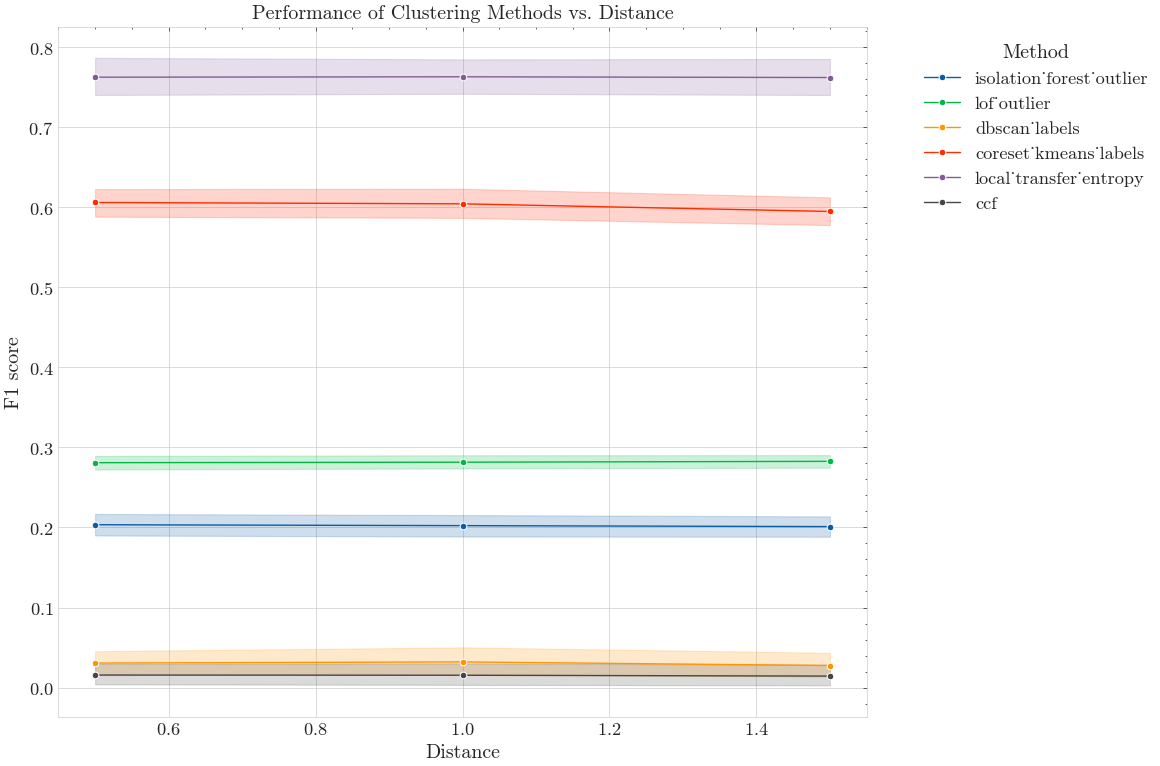

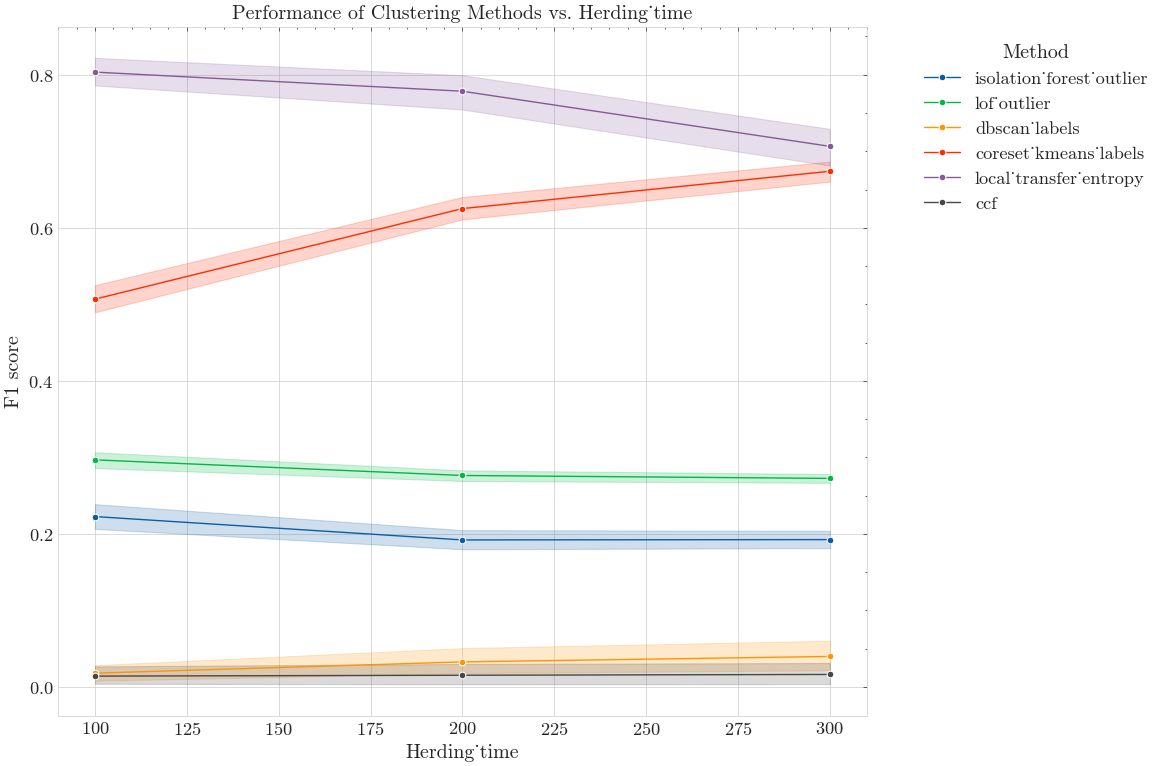

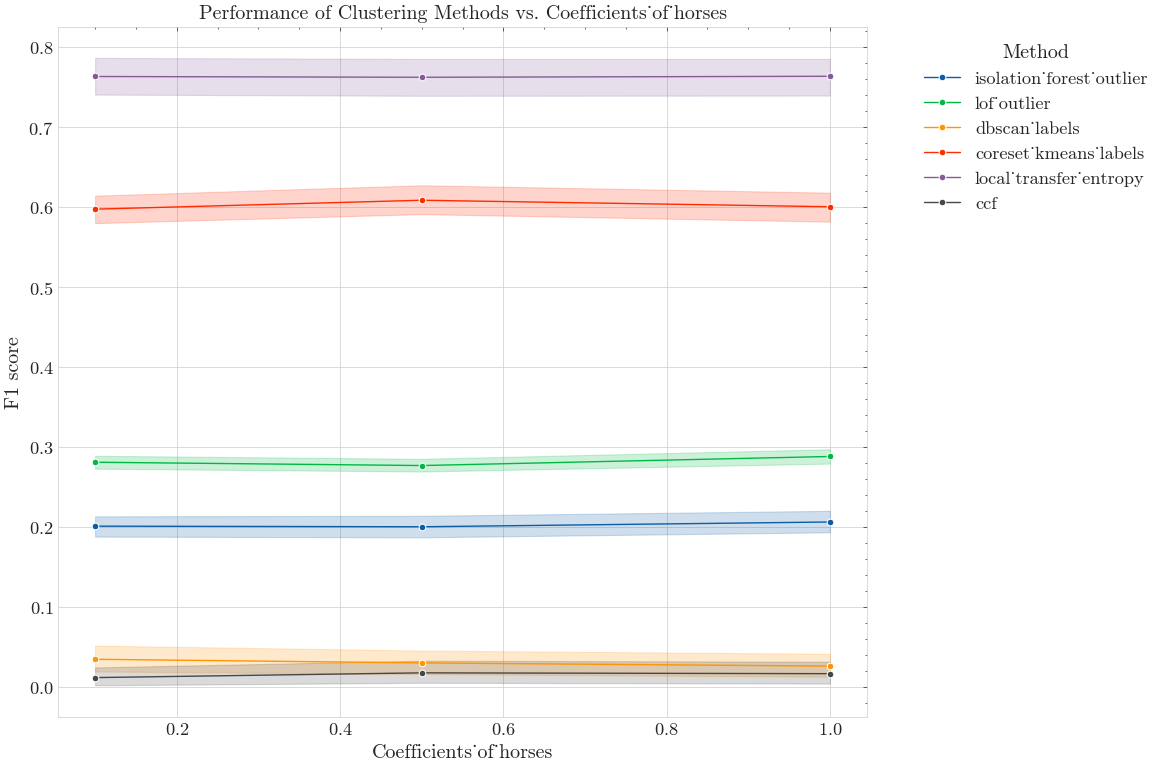

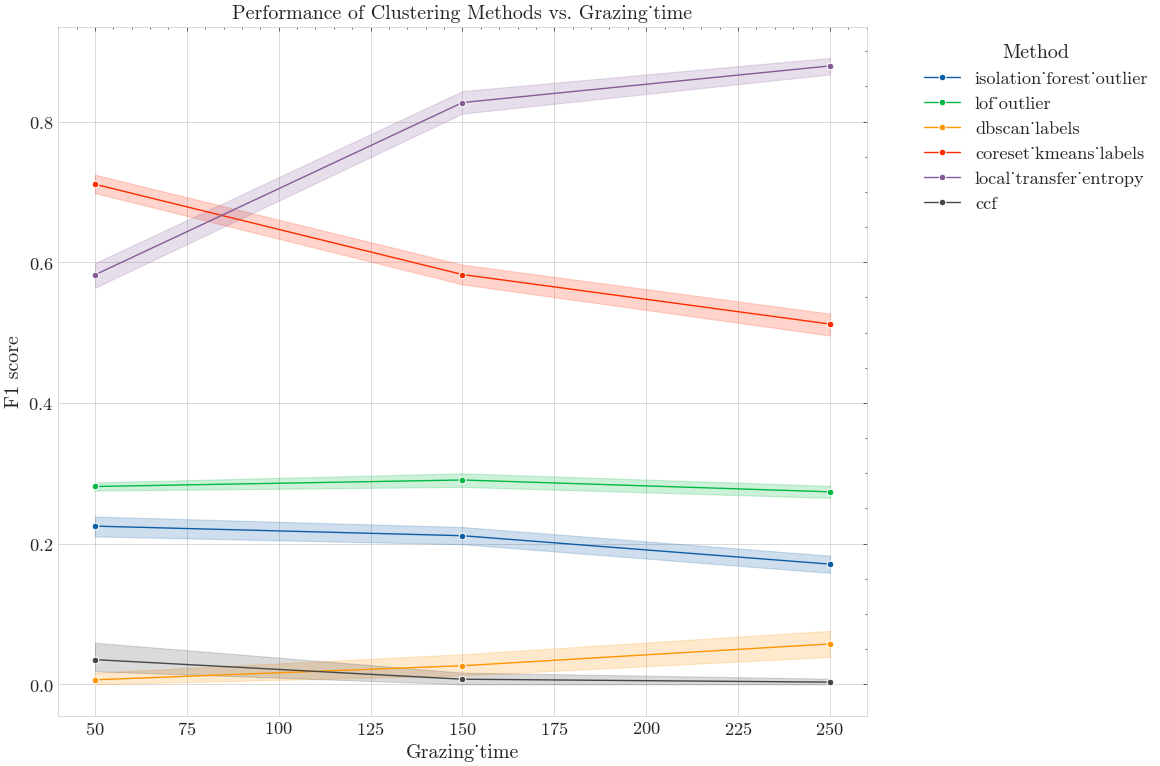

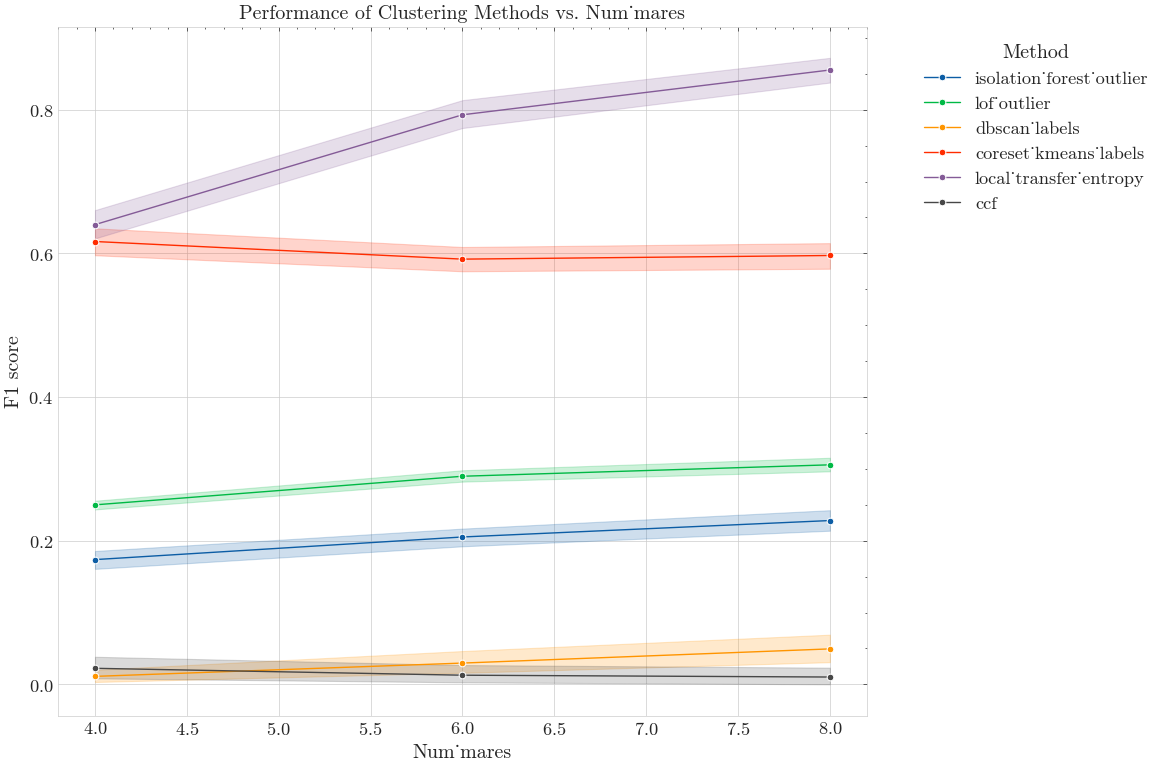

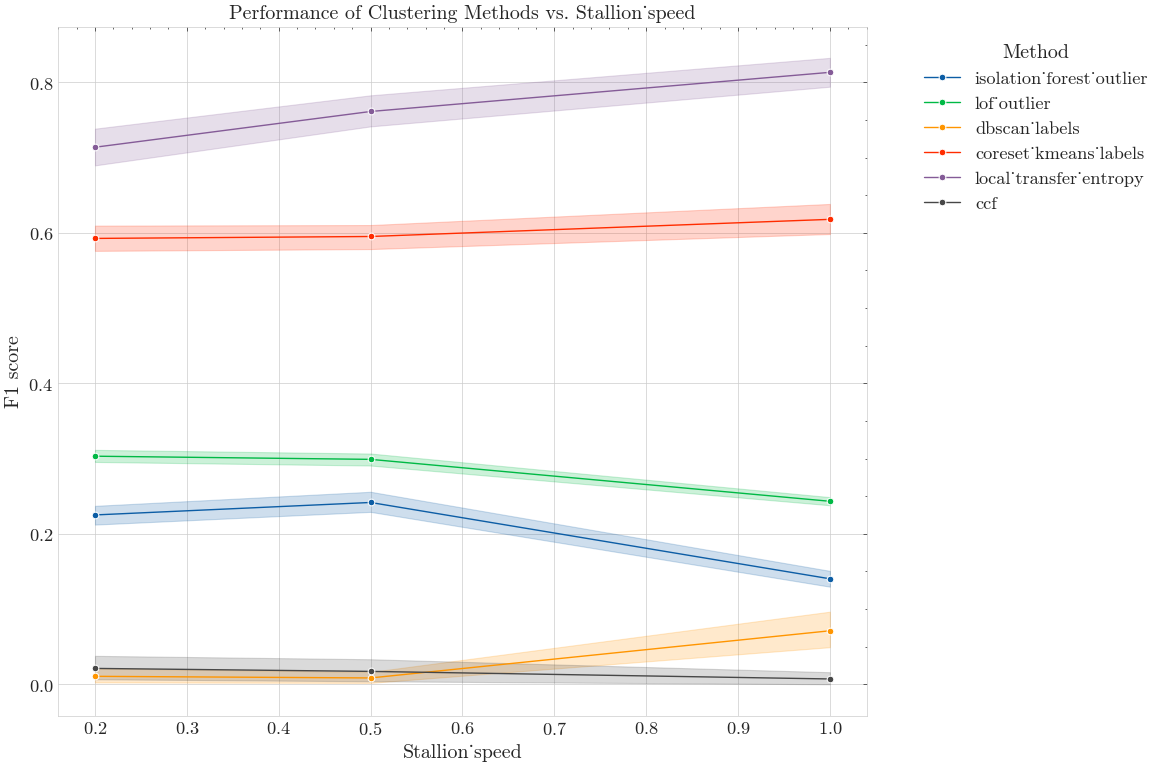

In [ ]:
# List of parameters to plot against
parameters_to_plot = ['distance', 'herding_time', 'coefficients_of_horses', 'grazing_time', 'num_mares', 'stallion_speed']

for param in parameters_to_plot:
    plot_performance(results_df, x_param=param)


In [ ]:
def plot_performance(results_df, x_param, hue_param='method', metric='f1_score'):
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=results_df, x=x_param, y=metric, hue=hue_param, marker='o',
        palette='colorblind', linewidth=2.5, markersize=10
    )
    plt.title(f'Performance of Clustering Methods vs. {x_param.replace("_", " ").capitalize()}', fontsize=18)
    plt.xlabel(f'{x_param.replace("_", " ").capitalize()}', fontsize=16)
    plt.ylabel(metric.replace('_', ' ').capitalize(), fontsize=16)
    plt.legend(title=hue_param.capitalize(), fontsize=12, title_fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    # Save the figure in high resolution
    plt.savefig(f'performance_vs_{x_param}.pdf', format='pdf')
    plt.show()


TypeError: plot_performance() missing 2 required positional arguments: 'results_df' and 'x_param'

### Permutation Test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pyinform
import warnings
import itertools
import seaborn as sns

# Suppress warnings from pyinform and other libraries for cleaner output
warnings.filterwarnings("ignore")

def simulate_herding_data(
    time_steps=30,
    num_mares=6,
    herding_start=11,
    herding_end=20,
    coefficients=None,
    grazing_std_dev=0.5,
    stallion_movement_distance=20,
    repulsion_stallion_distance=2,
    short_repulsion_distance=4,
    medium_attraction_distance=8,
    synchronization_distance=12,
    stallion_speed=2,
):
    # Set default coefficients if none are provided
    if coefficients is None:
        coefficients = {}
        for i in range(1, num_mares + 1):
            coefficients[f"mare{i}"] = {
                "inertia": 0.5,
                "repulsion_stallion": 0.4,
                "short_repulsion": 0.3,
                "medium_attraction": 0.2,
                "synchronization": 0.2,
                "com_attraction": 0.5,
            }

    # Initialize stallion and mare positions and velocities
    stallion_pos = np.array([[0.0, 0.0]])
    mare_positions = {}
    mare_velocities = {}
    for i in range(1, num_mares + 1):
        # Random initial positions for mares
        mare_positions[f"mare{i}"] = [np.random.uniform(-2, 2, size=2)]
        # Initial velocity is zero
        mare_velocities[f"mare{i}"] = [np.array([0.0, 0.0])]

    # Initialize DataFrame for simulation data
    simulation_data = pd.DataFrame({"time": np.arange(1, time_steps + 1)})

    for t in range(1, time_steps + 1):
        # Stallion Movement
        if t < herding_start or t > herding_end:
            # Grazing: small random movement
            stallion_move = np.random.normal(0, grazing_std_dev, size=2)
        else:
            # Herding: move towards a random target
            if t == herding_start:
                target = np.random.uniform(-stallion_movement_distance, stallion_movement_distance, size=2)
                stallion_direction = target - stallion_pos[-1]
                norm = np.linalg.norm(stallion_direction)
                if norm == 0:
                    stallion_direction = np.zeros(2)
                else:
                    stallion_direction /= norm
            stallion_move = stallion_speed * stallion_direction
        stallion_new_pos = stallion_pos[-1] + stallion_move
        stallion_pos = np.vstack([stallion_pos, stallion_new_pos])

        # Update mare positions
        if t < herding_start or t > herding_end:
            # Mares are grazing: small random movement
            for i in range(1, num_mares + 1):
                last_pos = mare_positions[f"mare{i}"][-1]
                grazing_move = np.random.normal(0, grazing_std_dev, size=2)
                new_vel = grazing_move
                new_pos = last_pos + new_vel
                mare_positions[f"mare{i}"].append(new_pos)
                mare_velocities[f"mare{i}"].append(new_vel)
        else:
            # Mares have complex behavior
            # Collect mare positions for calculations
            current_positions = []
            for i in range(1, num_mares + 1):
                current_positions.append(mare_positions[f"mare{i}"][-1])
            for i in range(1, num_mares):
                current_positions.append(stallion_pos[-1])
            current_positions = np.array(current_positions)

            # Calculate the center of mass (COM) of the mares
            com = np.mean(current_positions[:-1], axis=0)

            # Update each mare's position based on forces
            for i in range(1, num_mares + 1):
                coeffs = coefficients[f"mare{i}"]
                last_pos = mare_positions[f"mare{i}"][-1]
                last_vel = mare_velocities[f"mare{i}"][-1]

                # Inertia (normalized)
                if t == herding_start:
                    inertia_force = np.zeros(2)
                else:
                    inertia_force = last_vel
                inertia_force_norm = inertia_force / (np.linalg.norm(inertia_force) + 1e-6)

                # Repulsion from Stallion (normalized)
                vec_to_stallion = last_pos - stallion_pos[-1]
                dist_to_stallion = np.linalg.norm(vec_to_stallion)
                if dist_to_stallion < repulsion_stallion_distance:
                    repulsion_stallion_force = vec_to_stallion / (dist_to_stallion + 1e-6)
                else:
                    repulsion_stallion_force = np.zeros(2)

                # Short-Range Repulsion from other mares (normalized)
                short_repulsion_force = np.zeros(2)
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = last_pos - mare_positions[f"mare{j}"][-1]
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if dist_to_mare < short_repulsion_distance:
                            short_repulsion_force += vec_to_mare / (dist_to_mare + 1e-6)
                short_repulsion_force_norm = short_repulsion_force / (np.linalg.norm(short_repulsion_force) + 1e-6)

                # Medium-Range Attraction to other mares (normalized)
                medium_attraction_force = np.zeros(2)
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = mare_positions[f"mare{j}"][-1] - last_pos
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if short_repulsion_distance <= dist_to_mare < medium_attraction_distance:
                            medium_attraction_force += vec_to_mare / (dist_to_mare + 1e-6)
                medium_attraction_force_norm = medium_attraction_force / (np.linalg.norm(medium_attraction_force) + 1e-6)

                # Synchronization Attraction (normalized)
                synchronization_force = np.zeros(2)
                nearest_mare_vel = None
                min_dist = synchronization_distance
                for j in range(1, num_mares + 1):
                    if j != i:
                        vec_to_mare = mare_positions[f"mare{j}"][-1] - last_pos
                        dist_to_mare = np.linalg.norm(vec_to_mare)
                        if dist_to_mare < min_dist:
                            min_dist = dist_to_mare
                            nearest_mare_vel = mare_velocities[f"mare{j}"][-1]
                if nearest_mare_vel is not None:
                    synchronization_force = nearest_mare_vel
                    synchronization_force_norm = synchronization_force / (np.linalg.norm(synchronization_force) + 1e-6)
                else:
                    synchronization_force_norm = np.zeros(2)

                # Attraction to COM (normalized)
                vec_to_com = com - last_pos
                com_attraction_force = vec_to_com / (np.linalg.norm(vec_to_com) + 1e-6)

                # Combine forces with coefficients
                total_force = (
                    coeffs["inertia"] * inertia_force_norm
                    + coeffs["repulsion_stallion"] * repulsion_stallion_force
                    + coeffs["short_repulsion"] * short_repulsion_force_norm
                    + coeffs["medium_attraction"] * medium_attraction_force_norm
                    + coeffs["synchronization"] * synchronization_force_norm
                    + coeffs["com_attraction"] * com_attraction_force
                )
                total_force_norm = total_force / (np.linalg.norm(total_force) + 1e-6)

                # Update velocity and position
                speed = np.random.uniform(0.5, 1)  # Variable speed
                new_vel = speed * total_force_norm
                new_pos = last_pos + new_vel

                mare_positions[f"mare{i}"].append(new_pos)
                mare_velocities[f"mare{i}"].append(new_vel)

    # Collect simulation data
    for i in range(1, num_mares + 1):
        positions = np.array(mare_positions[f"mare{i}"])
        simulation_data[f"mare{i}_x"] = positions[1:, 0]
        simulation_data[f"mare{i}_y"] = positions[1:, 1]
    simulation_data["stallion_x"] = stallion_pos[1:, 0]
    simulation_data["stallion_y"] = stallion_pos[1:, 1]

    return simulation_data


def plot_herding(simulation_data, num_mares=6, herding_start=11, herding_end=20):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, num_mares))

    # Plot each mare's path with start and end markers, and highlight herding period
    for i in range(1, num_mares + 1):
        x = simulation_data[f"mare{i}_x"]
        y = simulation_data[f"mare{i}_y"]

        # Plot full path
        plt.plot(x, y, label=f"Mare {i}", color=colors[i - 1], alpha=0.5, linewidth=1.5)

        # Highlight herding period
        plt.plot(x.iloc[herding_start - 1:herding_end], y.iloc[herding_start - 1:herding_end], color=colors[i - 1], linewidth=2.5, alpha=0.9)

        # Mark start and end points
        plt.scatter(x.iloc[0], y.iloc[0], color=colors[i - 1], edgecolor="black", s=80, marker="o")
        plt.scatter(x.iloc[-1], y.iloc[-1], color=colors[i - 1], edgecolor="black", s=80, marker="X")

    # Plot stallion's path with markers for the herding period
    plt.plot(
        simulation_data["stallion_x"],
        simulation_data["stallion_y"],
        color="black",
        label="Stallion",
        linewidth=1.5,
        linestyle="--",
        alpha=0.7
    )

    # Mark herding period for stallion
    plt.plot(
        simulation_data["stallion_x"].iloc[herding_start - 1:herding_end],
        simulation_data["stallion_y"].iloc[herding_start - 1:herding_end],
        color="red",
        linewidth=2.5,
        linestyle="--",
        alpha=0.9,
        label="Stallion Herding"
    )

    # Add markers and labels for the stallion's start and end points
    plt.scatter(simulation_data["stallion_x"].iloc[0], simulation_data["stallion_y"].iloc[0], color="black", edgecolor="white", s=100, marker="o", label="Stallion Start")
    plt.scatter(simulation_data["stallion_x"].iloc[-1], simulation_data["stallion_y"].iloc[-1], color="black", edgecolor="white", s=100, marker="X", label="Stallion End")

    # Labels and grid
    plt.title("Simulated Herding and Grazing Behavior of Mares and Stallion Over Time")
    plt.rc('figure', titlesize=15)
    plt.rc('axes', labelsize=15)
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend(loc="upper right", fontsize="small", ncol=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


In [ ]:
def compute_observed_T(time_series_list):
    """
    Compute the observed average local transfer entropy across all horse pairs.

    Parameters:
    - time_series_list: List of numpy arrays, each representing a discretized time series for a mare.

    Returns:
    - T_obs: Numpy array of average local transfer entropy values per timestep.
    """
    n = len(time_series_list)
    T_length = len(time_series_list[0]) - 1  # pyinform computes TE up to len - 1
    num_pairs = n * (n - 1)
    local_TE_matrix = np.zeros((T_length, num_pairs))

    pair_index = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                xi = time_series_list[i]
                xj = time_series_list[j]
                # Compute local transfer entropy from xi to xj
                te_local = pyinform.transferentropy.transfer_entropy(
                    xi, xj, k=1, local=True
                )
                local_TE_matrix[:, pair_index] = te_local
                pair_index += 1
    # Average over all pairs at each time step
    T_obs = np.mean(local_TE_matrix, axis=1)
    return T_obs

def permute_time_series(time_series_list):
    """
    Permute each horse's time series independently.

    Parameters:
    - time_series_list: List of numpy arrays, each representing a discretized time series for a mare.

    Returns:
    - permuted_list: List of permuted numpy arrays.
    """
    permuted_list = []
    for series in time_series_list:
        permuted_series = np.random.permutation(series)
        permuted_list.append(permuted_series)
    return permuted_list

def compute_one_permutation(time_series_list):
    """
    Perform one permutation and compute the average transfer entropy.

    Parameters:
    - time_series_list: List of numpy arrays, each representing a discretized time series for a mare.

    Returns:
    - T_perm_p: Numpy array of average local transfer entropy values per timestep for this permutation.
    """
    permuted_data = permute_time_series(time_series_list)
    T_perm_p = compute_observed_T(permuted_data)
    return T_perm_p


In [ ]:
# Define hyperparameters
distance_values = [0.5, 1.0, 1.5]           # Stallion movement distance
herding_time_values = [100, 200, 300]      # Duration of herding events (time steps)
coefficients_of_horses_values = [0.1, 0.5, 1.0]  # Interaction coefficients between horses
grazing_time_values = [500, 1500, 2500]       # Duration of grazing periods (time steps)
num_mares_values = [4, 6, 8]               # Number of mares in the herd
stallion_speed_values = [0.2, 0.5, 1.0]    # Speed of the stallion

# Create hyperparameter grid
hyperparameter_grid = list(itertools.product(
    distance_values,
    herding_time_values,
    coefficients_of_horses_values,
    grazing_time_values,
    num_mares_values,
    stallion_speed_values
))

print(f"Total hyperparameter combinations: {len(hyperparameter_grid)}")


Total hyperparameter combinations: 729


In [ ]:
# Initialize a DataFrame to store results
results_columns = [
    'distance',
    'herding_time',
    'coefficients_of_horses',
    'grazing_time',
    'num_mares',
    'stallion_speed',
    'herding_start',
    'herding_end',
    'num_significant_timesteps',
    'true_positives',
    'false_positives',
    'false_negatives',
    'precision',
    'recall',
    'f1_score'
]

results_df = pd.DataFrame(columns=results_columns)


In [ ]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=results_columns)

# Define short_repulsion_distance as per your function
short_repulsion_distance = 4  # Adjust based on your simulation needs

# Number of permutations
P = 1000
alpha = 0.05

# Use tqdm for progress bar
for combo in tqdm(hyperparameter_grid, desc="Simulations"):
    distance, herding_time, coeff_of_horses, grazing_time, num_mares, stallion_speed = combo

    # Total time steps
    time_steps = grazing_time + herding_time

    # Randomize herding_start ensuring herding_end <= time_steps
    herding_start = np.random.randint(1, time_steps - herding_time + 1)
    herding_end = herding_start + herding_time

    # Define coefficients for each mare
    coefficients = {}
    for i in range(1, num_mares + 1):
        coefficients[f"mare{i}"] = {
            "inertia": coeff_of_horses,
            "repulsion_stallion": coeff_of_horses,
            "short_repulsion": coeff_of_horses,
            "medium_attraction": coeff_of_horses,
            "synchronization": coeff_of_horses,
            "com_attraction": coeff_of_horses,
        }

    # Generate synthetic data
    simulation_data = simulate_herding_data(
        time_steps=time_steps,
        num_mares=num_mares,
        herding_start=herding_start,
        herding_end=herding_end,
        coefficients=coefficients,
        grazing_std_dev=0.01,
        stallion_movement_distance=distance,
        repulsion_stallion_distance=2,
        short_repulsion_distance=short_repulsion_distance,
        medium_attraction_distance=8,
        synchronization_distance=12,
        stallion_speed=stallion_speed,
    )

    # Check if simulation_data is valid
    if simulation_data is None or simulation_data.empty:
        print(f"Simulation failed for combination: {combo}")
        continue

    # Extract mare positions
    mare_time_series = []
    for i in range(1, num_mares + 1):
        try:
            x = simulation_data[f"mare{i}_x"].values
            y = simulation_data[f"mare{i}_y"].values
            positions = np.vstack((x, y)).T  # Shape: (time_steps, 2)
            mare_time_series.append(positions)
        except KeyError:
            print(f"Missing data for mare{i} in combination: {combo}")
            mare_time_series = None
            break

    if mare_time_series is None:
        continue

    # Discretize the positions for pyinform (since it requires integer sequences)
    def discretize_positions(positions, bins=20):
        # Flatten positions to 1D for binning
        positions_1d = positions.flatten()
        # Compute bins using equal-width binning
        bin_edges = np.linspace(np.min(positions_1d), np.max(positions_1d), bins + 1)
        # Digitize positions
        digitized = np.digitize(positions_1d, bin_edges[:-1], right=False) - 1  # Zero-indexed
        # Handle edge case where value == max
        digitized[digitized == bins] = bins - 1
        # Reshape back to original shape
        digitized_positions = digitized.reshape(positions.shape)
        return digitized_positions

    # Discretize all mare positions
    bins = 10
    discretized_time_series = []
    for positions in mare_time_series:
        discretized_positions = discretize_positions(positions, bins=bins)
        # For simplicity, combine x and y into a single time series
        combined_series = discretized_positions[:, 0] * bins + discretized_positions[:, 1]
        discretized_time_series.append(combined_series.astype(int))

    # Compute observed average local transfer entropy
    T_obs = compute_observed_T(discretized_time_series)

    # Perform permutation test using joblib's Parallel
    permutation_results = Parallel(n_jobs=-1, verbose=0)(
        delayed(compute_one_permutation)(discretized_time_series) for _ in range(P)
    )

    # Convert permutation results to a numpy array for easier manipulation
    T_perm = np.array(permutation_results).T  # Shape: (T_length, P)

    # Calculate p-values
    p_values = np.mean(T_perm >= T_obs[:, np.newaxis], axis=1)

    # Identify significant timesteps
    significant_timesteps = np.where(p_values < alpha)[0] + 1  # Adjusting index to match time steps

    # Determine true positives, false positives, false negatives
    # True positives: significant timesteps within herding period
    tp = np.sum((significant_timesteps >= herding_start) & (significant_timesteps <= herding_end))

    # False positives: significant timesteps outside herding period
    fp = np.sum((significant_timesteps < herding_start) | (significant_timesteps > herding_end))

    # False negatives: herding timesteps not detected
    detected_timesteps = set(significant_timesteps)
    herding_timesteps = set(range(herding_start, herding_end + 1))
    fn = len(herding_timesteps - detected_timesteps)

    # Precision, Recall, F1 Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (herding_time) if herding_time > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Record results as a DataFrame
    result_df = pd.DataFrame([{
        'distance': distance,
        'herding_time': herding_time,
        'coefficients_of_horses': coeff_of_horses,
        'grazing_time': grazing_time,
        'num_mares': num_mares,
        'stallion_speed': stallion_speed,
        'herding_start': herding_start,
        'herding_end': herding_end,
        'num_significant_timesteps': len(significant_timesteps),
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }])

    # Concatenate the new result with the existing results_df
    results_df = pd.concat([results_df, result_df], ignore_index=True)

    # Optional: Save intermediate results every 100 simulations
    if len(results_df) % 100 == 0:
        results_df.to_csv('herding_detection_results.csv', index=False)


NameError: name 'results_columns' is not defined

#### Singular Example

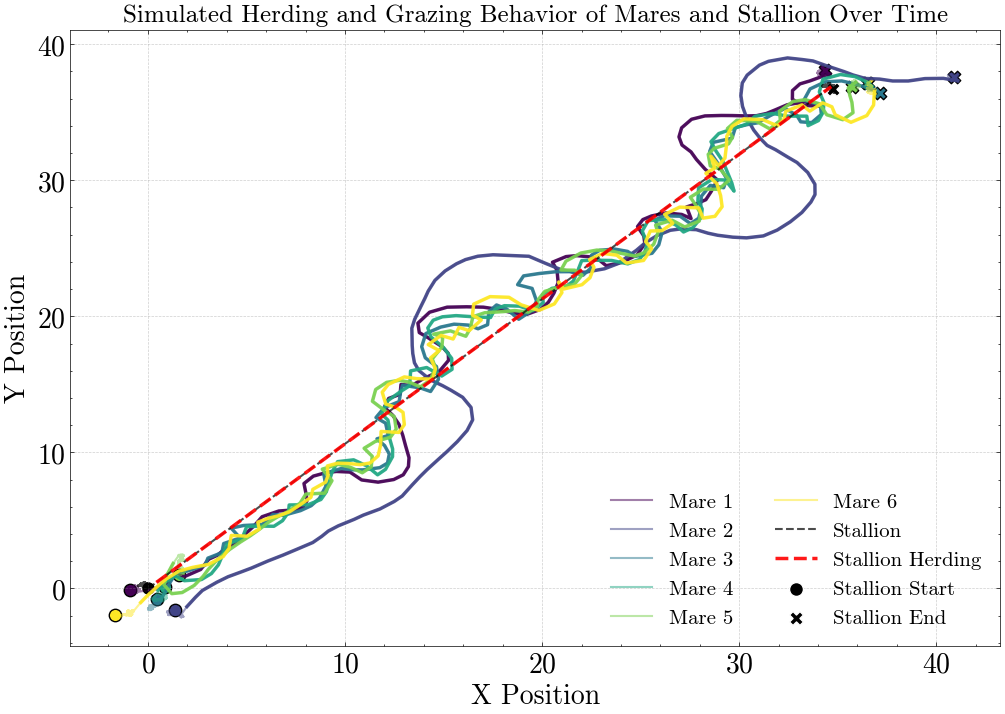

In [ ]:
# Define number of mares and their coefficients
num_mares = 6
coefficients = {}
for i in range(1, num_mares + 1):
    coefficients[f"mare{i}"] = {
        "inertia": np.random.uniform(0.4, 1.0),
        "repulsion_stallion": np.random.uniform(0.2, 0.4),
        "short_repulsion": np.random.uniform(0.0, 0.4),
        "medium_attraction": np.random.uniform(0.0, 0.5),
        "synchronization": np.random.uniform(0.0, 0.4),
        "com_attraction": np.random.uniform(0, 1.0),
    }

# Run the simulation
simulation_data = simulate_herding_data(
    time_steps=4000,
    num_mares=num_mares,
    herding_start=1900,
    herding_end=2000,
    coefficients=coefficients,
    grazing_std_dev=0.01,
    stallion_movement_distance=10,
    stallion_speed=0.5,
)

# Plot the herding behavior
plot_herding(simulation_data, num_mares=num_mares, herding_start=1900, herding_end=2000)

In [ ]:
# Extract mare positions
mare_time_series = []
for i in range(1, num_mares + 1):
    x = simulation_data[f"mare{i}_x"].values
    y = simulation_data[f"mare{i}_y"].values
    positions = np.vstack((x, y)).T  # Shape: (time_steps, 2)
    mare_time_series.append(positions)

# Discretize the positions for pyinform (since it requires integer sequences)
def discretize_positions(positions, bins=10):
    # Flatten positions to 1D for binning
    positions_1d = positions.flatten()
    # Compute bins using equal-width binning
    bin_edges = np.linspace(np.min(positions_1d), np.max(positions_1d), bins + 1)
    # Digitize positions
    digitized = np.digitize(positions_1d, bin_edges[:-1], right=False) - 1  # Zero-indexed
    # Handle edge case where value == max
    digitized[digitized == bins] = bins - 1
    # Reshape back to original shape
    digitized_positions = digitized.reshape(positions.shape)
    return digitized_positions

# Discretize all mare positions
bins = 20
discretized_time_series = []
for positions in mare_time_series:
    discretized_positions = discretize_positions(positions, bins=bins)
    # For simplicity, combine x and y into a single time series
    combined_series = discretized_positions[:, 0] * bins + discretized_positions[:, 1]
    discretized_time_series.append(combined_series.astype(int))

# Compute observed average local transfer entropy
T_obs = compute_observed_T(discretized_time_series)

# Number of permutations
P = 1000
alpha = 0.1

# Perform permutation test using joblib's Parallel
permutation_results = Parallel(n_jobs=-1, verbose=0)(
    delayed(compute_one_permutation)(discretized_time_series) for _ in range(P)
)

# Convert permutation results to a numpy array for easier manipulation
T_perm = np.array(permutation_results).T  # Shape: (T_length, P)

# Calculate p-values
p_values = np.mean(T_perm >= T_obs[:, np.newaxis], axis=1)

# Identify significant timesteps
significant_timesteps = np.where(p_values < alpha)[0] + 1  # Adjusting index to match time steps

# Output summary
print(f"Number of significant timesteps: {len(significant_timesteps)}")
print(f"True Positives (within herding period): {np.sum((significant_timesteps >= 1900) & (significant_timesteps <= 2000))}")
print(f"False Positives (outside herding period): {np.sum((significant_timesteps < 1900) | (significant_timesteps > 2000))}")
print(f"False Negatives (herding period not detected): {100 - np.sum((significant_timesteps >= 1900) & (significant_timesteps <= 2000))}")


Number of significant timesteps: 75
True Positives (within herding period): 75
False Positives (outside herding period): 0
False Negatives (herding period not detected): 25


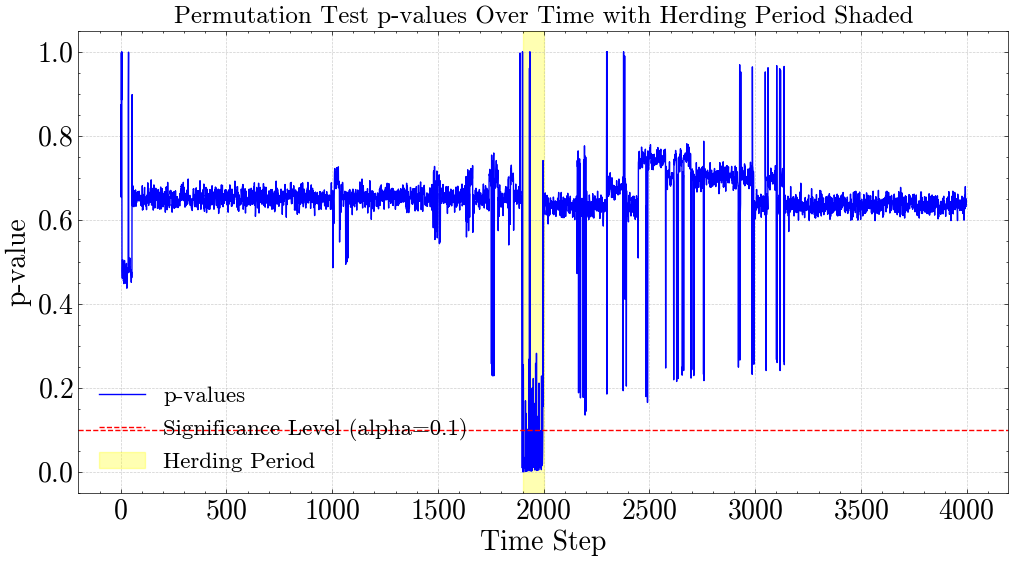

In [ ]:
# Visualize p-values over time with shaded herding period
plt.figure(figsize=(12, 6))
plt.plot(p_values, label='p-values', color='blue')
plt.axhline(y=alpha, color='red', linestyle='--', label=f'Significance Level (alpha={alpha})')

# Shaded region for herding period
plt.axvspan(1900, 2000  , color='yellow', alpha=0.3, label='Herding Period')

plt.xlabel('Time Step')
plt.ylabel('p-value')
plt.title('Permutation Test p-values Over Time with Herding Period Shaded')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### Aggregate Statistics

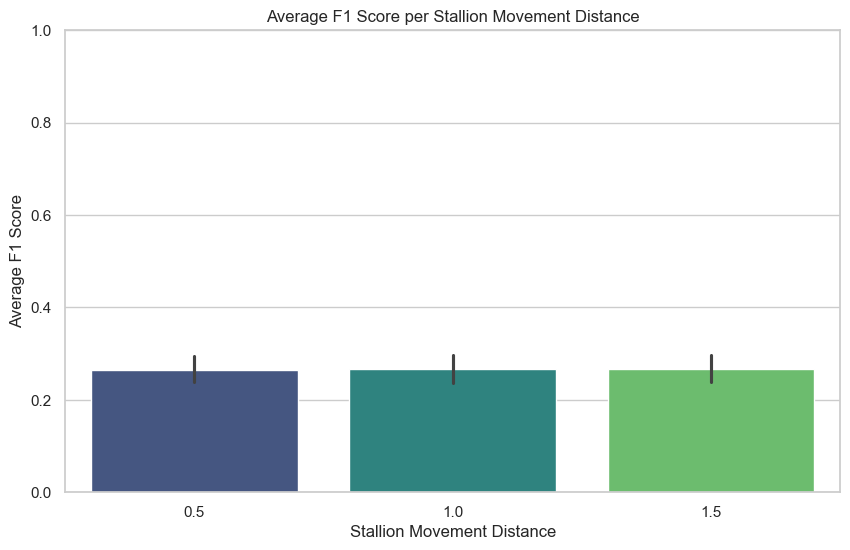

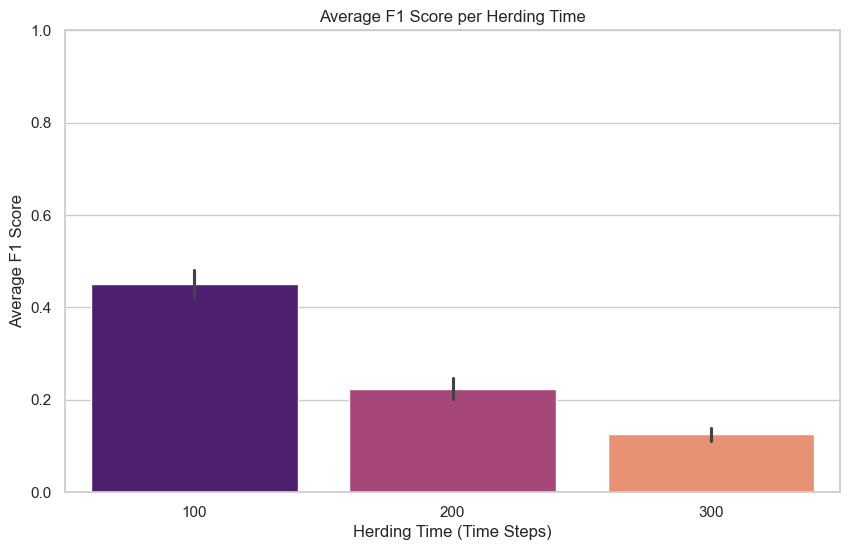

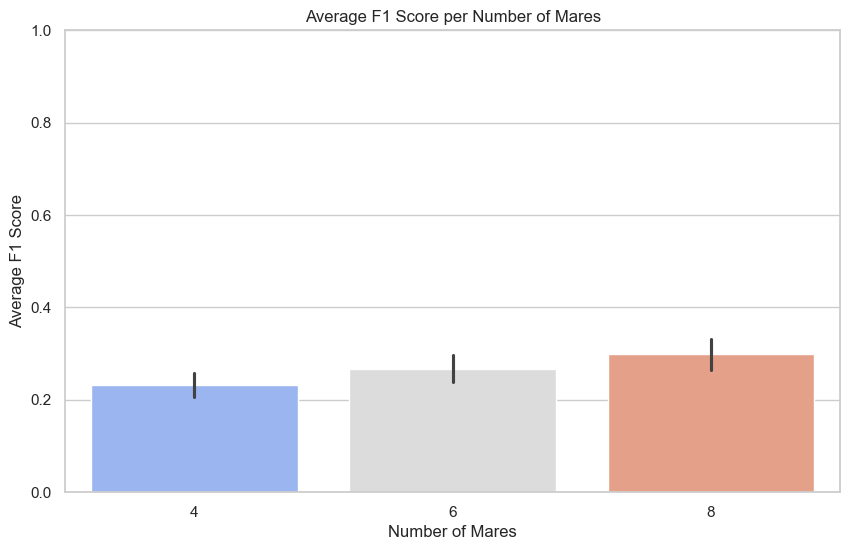

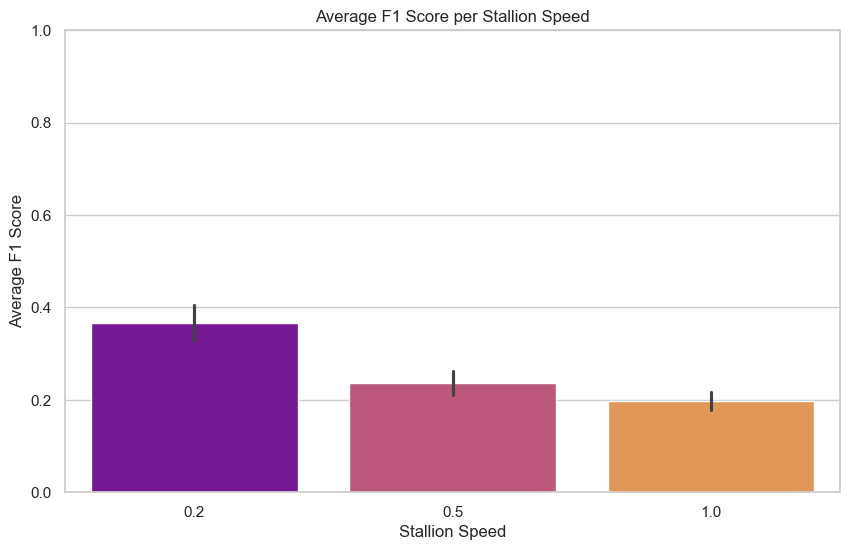

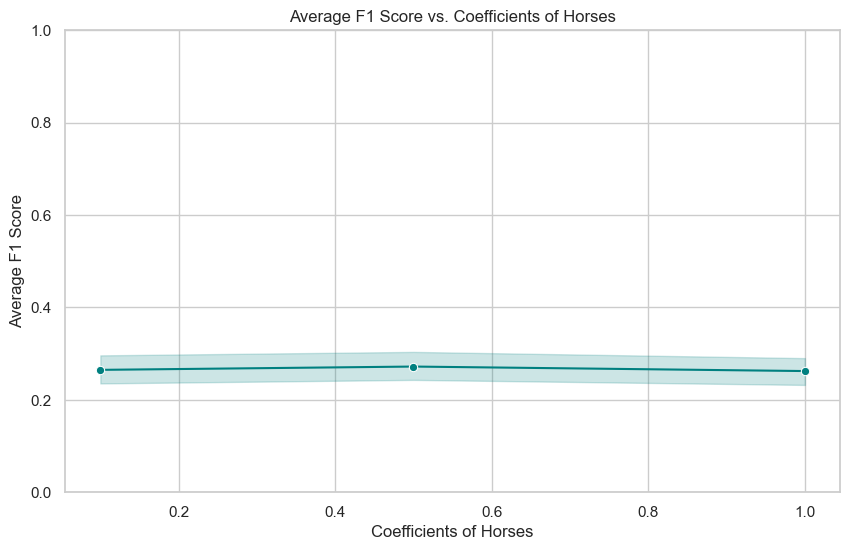

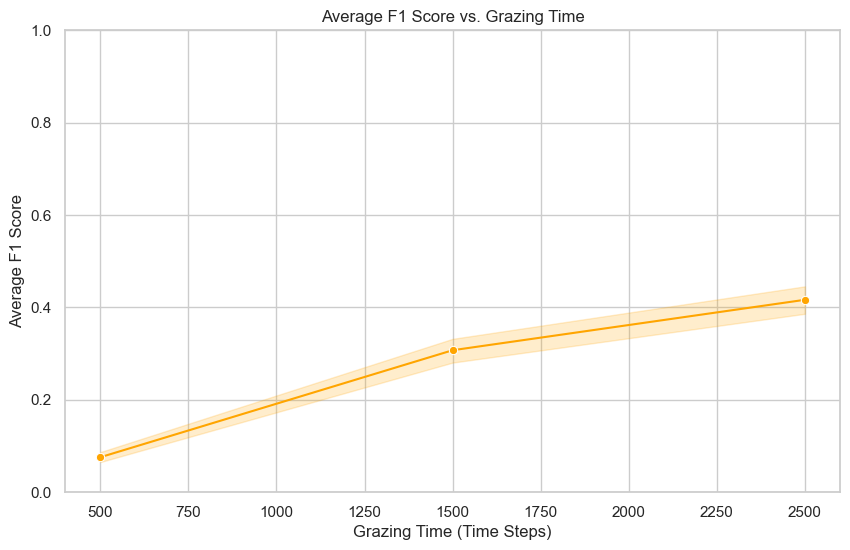

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that your results_df is populated with simulation results
if not results_df.empty:
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Plot 1: Average F1 Score per Stallion Movement Distance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='distance', y='f1_score', data=results_df, palette='viridis')
    plt.xlabel('Stallion Movement Distance')
    plt.ylabel('Average F1 Score')
    plt.title('Average F1 Score per Stallion Movement Distance')
    plt.ylim(0, 1)
    plt.show()

    # Plot 2: Average F1 Score per Herding Time
    plt.figure(figsize=(10, 6))
    sns.barplot(x='herding_time', y='f1_score', data=results_df, palette='magma')
    plt.xlabel('Herding Time (Time Steps)')
    plt.ylabel('Average F1 Score')
    plt.title('Average F1 Score per Herding Time')
    plt.ylim(0, 1)
    plt.show()

    # Plot 3: Average F1 Score per Number of Mares
    plt.figure(figsize=(10, 6))
    sns.barplot(x='num_mares', y='f1_score', data=results_df, palette='coolwarm')
    plt.xlabel('Number of Mares')
    plt.ylabel('Average F1 Score')
    plt.title('Average F1 Score per Number of Mares')
    plt.ylim(0, 1)
    plt.show()

    # Plot 4: Average F1 Score per Stallion Speed
    plt.figure(figsize=(10, 6))
    sns.barplot(x='stallion_speed', y='f1_score', data=results_df, palette='plasma')
    plt.xlabel('Stallion Speed')
    plt.ylabel('Average F1 Score')
    plt.title('Average F1 Score per Stallion Speed')
    plt.ylim(0, 1)
    plt.show()

    # Plot 5: Average F1 Score per Coefficients of Horses
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='coefficients_of_horses', y='f1_score', data=results_df, marker='o', color='teal')
    plt.xlabel('Coefficients of Horses')
    plt.ylabel('Average F1 Score')
    plt.title('Average F1 Score vs. Coefficients of Horses')
    plt.ylim(0, 1)
    plt.show()

    # Plot 6: Average F1 Score per Grazing Time
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='grazing_time', y='f1_score', data=results_df, marker='o', color='orange')
    plt.xlabel('Grazing Time (Time Steps)')
    plt.ylabel('Average F1 Score')
    plt.title('Average F1 Score vs. Grazing Time')
    plt.ylim(0, 1)
    plt.show()
else:
    print("The results_df DataFrame is empty. Please ensure that simulations have been run and results are recorded.")
